# Extracting the MIB and SIB1 from an LTE Signal

This notebook walks through the processing a received LTE signal from preliminary analysis through recovery of timing information and decoding of the cell ID, extraction of the MIB, and processing steps towards recovering SIB1.

<a href="https://colab.research.google.com/github/bepepa/giti_lectures/blob/master/LTE_MIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/giti_lectures/blob/main/LTE_MIB.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# signal processing toolbox
from scipy import signal

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Load data and perform basic checks


In [2]:
# read the metadata file
import json

meta_file = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-meta'
data_file = 'data/LTE_downlink_806MHz_2022-04-09_30720ksps.sigmf-data'

with open(meta_file) as f:
    meta_data = json.load(f)
    
meta_data

{'global': {'core:author': 'Daniel Estévez <daniel@destevez.net>',
  'core:datatype': 'ci16_le',
  'core:description': 'Recording of the LTE downlink signal of the Vodafone PCI 380 cell at Movistar Plus+ headquarters (10 MHz B20 channel)',
  'core:geolocation': {'coordinates': [-3.69678, 40.598363], 'type': 'Point'},
  'core:hw': 'USRP B205mini',
  'core:license': 'https://creativecommons.org/licenses/by/4.0/',
  'core:recorder': 'GNU Radio 3.9',
  'core:sample_rate': 30720000,
  'core:sha512': '0beac70c602caa65765bdbad8cafaf8ede7392106322a96188c4b3f48b4167ecc8e4e9414bf09af8058b9d8ce8919c413d570ef1e9d8c4d4507dfdc903ebf836',
  'core:version': '1.0.1'},
 'captures': [{'core:datetime': '2022-04-09T11:09:33.123597',
   'core:frequency': 806000000,
   'core:sample_start': 0}],
 'annotations': []}

From the meta-information, we see that the center frequency for the collect is 806MHz. 

This is the center frequency for the downlink of LTE band 20, which is used in the EU (Digital Dividend Band). It has an allocated bandwidth of 30MHz.

It is licensed for FDD use.

In [3]:
# Get the sample rate, carrier frequency, and the data type
Fs = meta_data['global']['core:sample_rate']
fc = meta_data['captures'][0]['core:frequency']
dtype = meta_data['global']['core:datatype']

In [4]:
# read the entire data file and convert to complex samples
tmp = np.fromfile(data_file, dtype=np.int16)

scale = 2.0**(-15)

rx = scale * tmp[0::2] + 1j * scale * tmp[1::2]

### Preliminary Signal Analysis

To verify the integrity of the signal, the power spectral density (PSD) and the spectrogram of the received signal is computed and plotted.

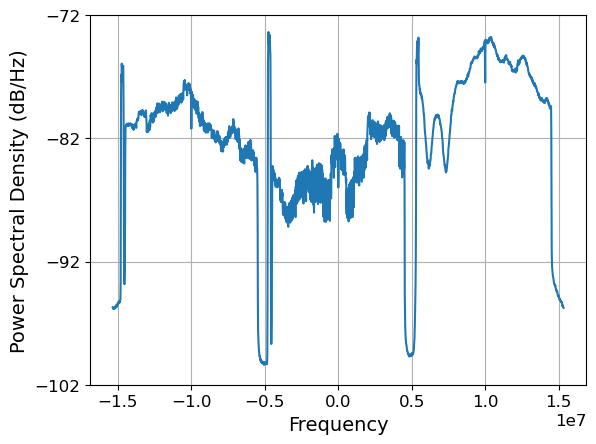

In [5]:
# First the PSD
Pxx, ff = plt.psd(rx[:], Fs=Fs, NFFT=2048)
# plt.xlim(-5e6, 5e6)
plt.show()

The PSD indicates that the received signal contains *three* signals of close to 10 MHz bandwidth each. There appear to be additional narrowband signals in the gaps between these signals - the origin and purpose of these signals is not clear. We will take a closer look at each of these signals below.

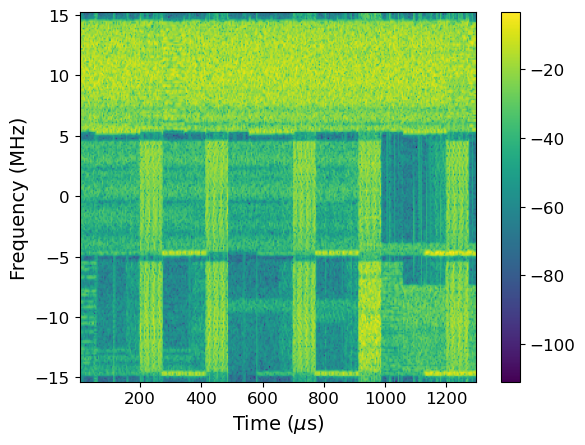

In [6]:
# For the spectrogram, we restrict the duration to about 1ms
# to reveal temporal structures
plt.specgram(rx[:40000], Fs=Fs/1e6)
plt.colorbar()
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Frequency (MHz)')
plt.show()

For an OFDM signal with $\Delta f=$ 15 KHz subcarrier spacing, each symbol is $T_s = \frac{1}{\Delta f}$ (approximately 70 $\mu s$) long. 

The two signals at the bottom of the spectrogram exhibit features that are consistent with this subcarrier spacing. Hence, we can conclude that they are likely OFDM signals.

The top signal does not exhibit a temporal structure; it is not clear that this is an OFDM signal.

The two signals at the bottom also appear to be symbol-synchronous.

For a closer examination of the three signals, we zoom in on each of the 10MHz bands, beginning with the band in the center.

A nominally 10 MHz wide LTE signal contains 50 resource blocks (RB), which in turn is made up of 12 subcarriers. Hence, the bandwidth of such a signal is $50 \cdot  12 \cdot 15 \text{ KHz} = 9.0 \text{ MHz}$. The red dashed lines in the plot below indicate the bandlimits of a 9 MHz bandwidth.

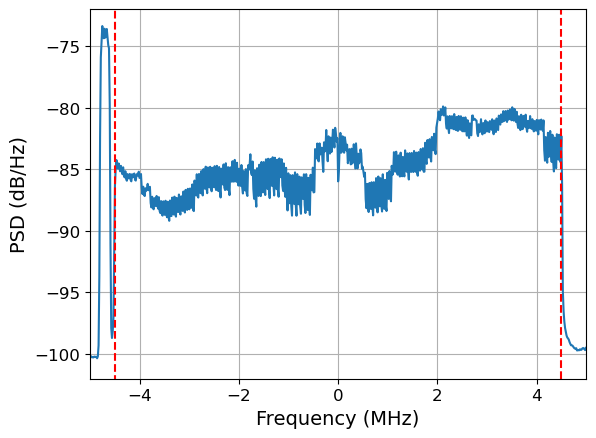

In [7]:
# PSD of center band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([-4.5, -4.5], [-105, -72], 'r--')
plt.plot([4.5, 4.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(-5, 5)
plt.ylim(-102, -72)  

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The signal has a bandwidth of 9 MHz. 

The narrowband signal below -4.5MHz is clearly visible - it does not appear to be an OFDM signal. From the spectrogram, it does not appear to be synchronous with the OFDM symbols.

The "jagged" nature of the PSD is consistent with moduted subcarriers.

The center carrier appears to be suppressed; this is indicative of an LTE (not 5G) signal.

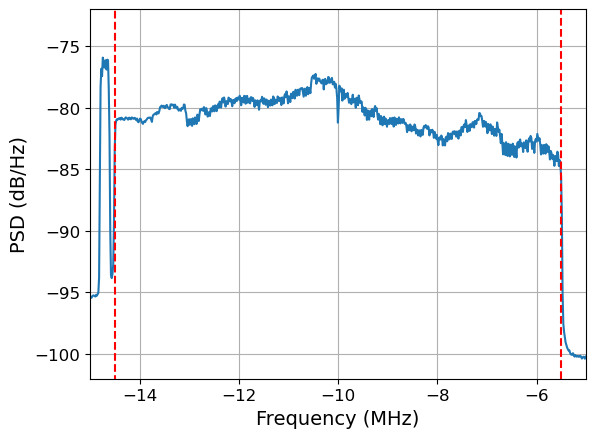

In [8]:
# PSD of lower band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([-14.5, -14.5], [-105, -72], 'r--')
plt.plot([-5.5, -5.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(-15, -5)
plt.ylim(-102, -72)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The second PSD is very simlar in all respect to the signal in the center of the band.

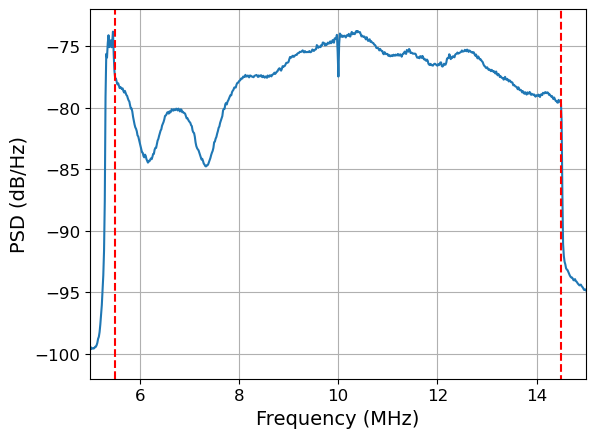

In [9]:
# PSD of upper band
#plt.psd(rx[:], Fs=Fs, NFFT=2048)
plt.plot(ff/1e6, 10*np.log10(Pxx))
plt.plot([14.5, 14.5], [-105, -72], 'r--')
plt.plot([5.5, 5.5], [-102, -72], 'r--')

plt.grid()

plt.xlim(5, 15)
plt.ylim(-102, -72)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (MHz)')
plt.show()

The signal in the upper band is also an LTE signal. This band appears to be much more heavily loaded than the other two. 

### Signal Separation

We will separate the three signal using frequency translation (if needed) and low-pass filtering.

It may be possible to accomplish signal separation in the frequency domain (i.e., after taking the DFT, subcarriers outside the band of interest are suppressed).

However, it appears safer to remove (filter) signals outside the band of interest. Detection of the synchronization signal requires time-domain correlation which will be affected by the out-of-band signals.

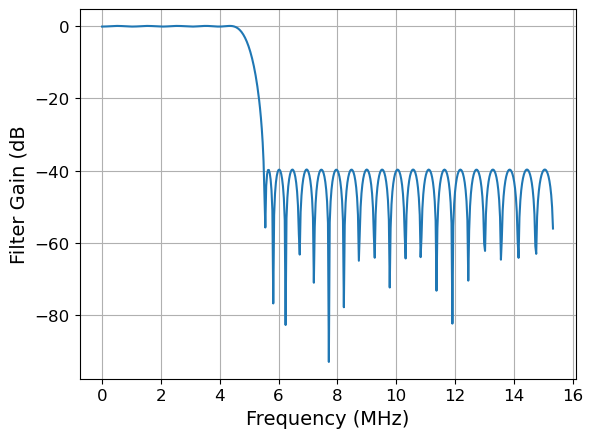

In [10]:
# design an FIR filter with (one-sided) bandwidth 4.5MHz
h = signal.remez(60, [0, 4.5e6, 5.5e6, Fs/2], [1, 0], fs=Fs)
w, H = signal.freqz(h, fs=Fs)

plt.plot(w/1e6, 20*np.log10(np.abs(H)))
plt.grid()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Filter Gain (dB')

plt.show()

#### Filtering

We will process the upper band, as it is the most heavily used band (the other bands also do not appear to contain a SIB1). 

For that purpose, we first down-convert the signal by 10MHz so that the center frequency of the upper band is shifted to the center of the observed bandwidth. 

Then, the center band is extracted using the filter we just designed.

In [11]:
# filter the signal
fc = 10e6 # for lower band set to -10e6; for upper band, set to 10e6 (doesn't find PSS)
rxf = np.convolve(rx * np.exp(-2j * np.pi * fc * np.arange(len(rx)) / Fs), h)

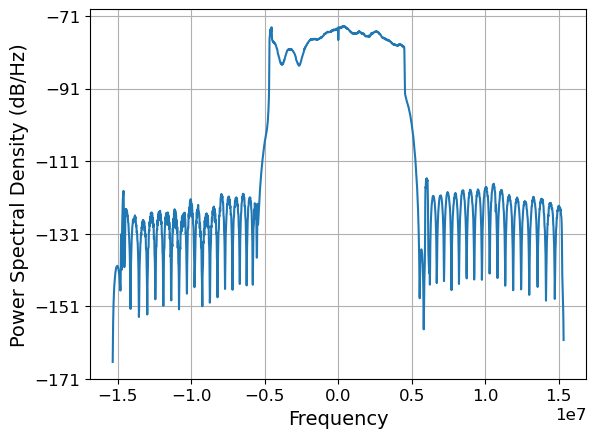

In [14]:
# verify that this worked - only the center signal should be visible
Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=2048)
plt.ylim(-102, -72)

plt.show()

As the signal is more than twice oversampled, we reduce the sampling rate by a factor of 2. This alleviates some of the signal processing complexity and removes unused subcarriers.

Note that changing the sampling rate, also requires us to adjust the FFT length (to 1024 subcarriers) and the length of the cyclic prefix (to 72 samples, respectively 80 samples for the first symbol in each slot).

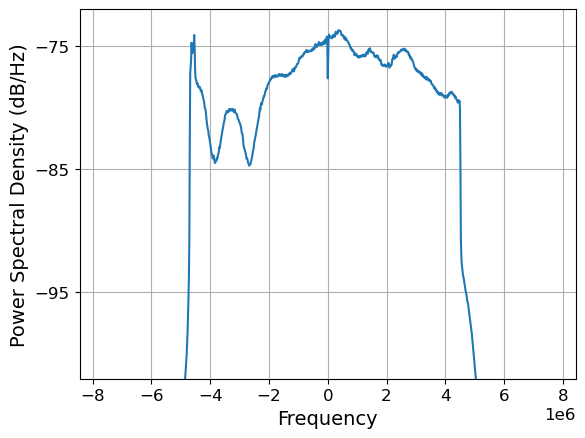

In [12]:
## Down-sample the signal by a factor of 2
rxf = rxf[::2]
Fs = Fs/2

# system parameters
df_sc = 15e3
N_FFT = int(Fs / df_sc)
N_CP = 144 // (2048 // N_FFT)
N_CP_extra = 16 // (2048 // N_FFT)

# plot the spectrum again
Pxx, ff = plt.psd(rxf, Fs=Fs, NFFT=N_FFT)
plt.ylim(-102, -72)

plt.show()

## What is Where

Before we dive into the details of processing the received signal, we will first orient ourselves where in time and frequency within a frame the various information elements are located. We will refere back to the *resource grid* below frequently.

The resource grid for an LTE FDD frame shows where in time and frequency the signals and channels of interest are located:

![LTE Reource Grid for FDD frames]( LTE_Resource_Grid.png) <img src="LTE_Resource_Grid_Legend.png" height="100" alt="Legend">

Note: even though this resource grid is for a 1.4MHz wide channel it still shows the location of most of the elements we're interested in accurately.

Towards the goal of isolating and extracting information from the SIB, we will need to process the following signals and channels in the order below:
* **PSS and SSS** for initial synchronization in time and frequency; PSS and SSS also inform the cell id. The PSS always appear in the last symbol of slot 0 and 10 of every frame. The SSS location differs for FDD (frame structure type 1) and TDD (frame structure type 2) frames. For FDD, the SSS signal appears in the symbol immediately before the PSS. For TDD, the SSS appears in the last symbol slots 1 and 11. (TS 36.211, section 6.11)
* **CRS (cell-specific reference signals** are used to provide channel estimates for equalization and transmit diversity (space-time coding). CRS signals are sent in every down-link subframe. Different reference sequences are sent on different resource element from each antenna so that the channel from each TX antenna to the UE can be measured. (TS 36.211, section 6.10.1).
* **PBCH (Physical Broadcast Channel)** The PBCH carries the Master Information Block MIB). It is heavily coded and transmitted in the first four symbols of slot 1. The information in the MIB is repeated over four consecutive frames before it changes (at least the syste frame namber SFN will change). The PBCH uses QPSK modulation and therefore requires equalization and transmit diversity combining using the channel estimates from the CRS. (TS 36.211, section 6.6)  
 *Result:* Contents of Master Information Block (MIB)
* **PCFICH (Physical Control Format Indicator Channel):** This control channel indicates how many symbols in each subframe are allocated for the control channel (PDCCH). The number of symbols for control varies between 1 and 3 in each subframe. This channel indicates which of the three options is used. It is transmitted in the first symbol of every subframe. (TS 36.211, section 6.7)
* **PDCCH (Physical Downlink Control Channel):** contains information about either where a UE may transmit in the uplink direction or where the UE can find either unicast data or broadcast control information (including SIBs) in the down-link direction.  
The PDCCH occupies the first $n$ symbols of every subframes, where $n$ is indicated by the PCFICH. (TS 36.211, section 6.8). Within the PDCCH, the location of Downlink Control Information (DCI) is not fixed. Instead, the UE must search different possibile locations that are enumerated in a search space; it can determine that it has found relevant DCI when demodulation succeeds as indicated by the CRC.  
 *Result:* The UE learns where (in time and frequency) it can received the SIB.
* **PDSCH (Physical Downlink Shared Channel):** The actual SIB is carried on a PDSCH (i.e., a regular taffic channel).

## Task: Initial Synchronization

Now that we have isolated a single LTE band, we need to recover the timing of the LTE signal. 

Specifically, we want to identify the location of symbol boundaries and possibly even slot boundaries.

The primary synchronization signal (PSS) is intended for specifically this purpose. 

However, the PSS appear only once every 5ms. The search for the PSS is computationally expensive.

We can leverage the cyclic prefix (CP) that appears in every symbol to obtain an initial estimate of the symbol timing.

**Possible Improvement:** Initial processing, including detection of PSS and SSS as well as extraction of the MIB can be done at a reduced sampleing rate (of 1.92MHz, i.e., 128 subcarriers) as PSS, SSS, and PBCH are confined to the center 6 resource blocks (72 subcarriers). Operating at reduced sampling rate reduces the signal processing burden (especially correlation) and eliminates interference from other subcarriers during PSS search.

### Detecting the Cyclic Prefix

The cyclic prefix repeats the last $N_{CP}$ samples of an OFDM symbol before the start of the symbol.

Hence, we should see highly correlated samples separated by $N_{FFT}$ samples at the beginning of the cyclic prefix.

The code below computes this correlation for each sample instance $n$ over the first 14 OFDM symbol periods (i.e., one frame).

In [14]:
# compute the length-N_CP autocorrelation at lag N_FFT over time
N_syms = 14
N = N_syms*(N_FFT + N_CP)
corr = np.zeros(N, dtype=complex)

for n in range(N):
    seg1 = rxf[n : n+N_CP]
    m = n + N_FFT
    seg2 = rxf[m : m+N_CP]

    corr[n] = np.sum(seg2 * seg1.conj())

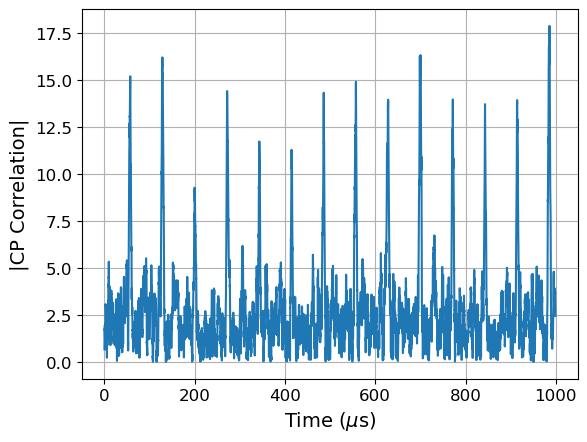

In [15]:
# plot the correlation
plt.plot(np.arange(N)/Fs*1e6, np.abs(corr))
plt.grid()

plt.xlabel('Time ($\mu$s)')
plt.ylabel('|CP Correlation|')

plt.show()

There are 14 peaks in the plot above; i.e., exactly as many peaks as there are symbols in the 1ms duration of the frame.

Let's find the location (sample number) of the above peaks. We will use these locations to anchor our search for the PSS below.

To find the peaks, we divide the frame into 14 symbol periods (length `N_FFT + N_CP` samples) and search for the location of the maximum in each period.

In [21]:
# find the peak locations
locs = np.zeros(N_syms, dtype=int)
corr_vals = np.zeros(N_syms)

for n in range(N_syms):
    n_start = n * (N_FFT + N_CP)
    n_end = n_start + (N_FFT + N_CP)

    locs[n] = np.argmax(np.abs(corr[n_start : n_end])) + n_start
    corr_vals[n] = np.abs(corr[locs[n]])

# locs, corr_vals
# np.diff(locs) - (N_FFT + N_CP)

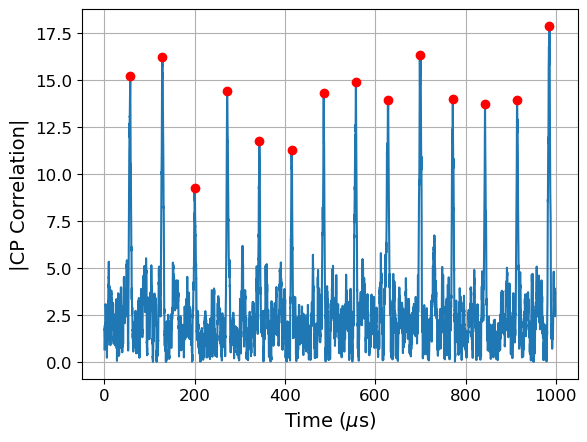

In [22]:
# plot the correlation and mark the location of the detected peaks
plt.plot(np.arange(N)/Fs*1e6, np.abs(corr))
plt.plot(locs/Fs*1e6, corr_vals, 'ro')
plt.grid()

plt.xlabel('Time ($\mu$s)')
plt.ylabel('|CP Correlation|')

plt.show()

### Fine Estimation of correlation peaks

The correlation peaks mark the point immediately after the cyclic prefix in each symbols. The frequency offset is estimated using the phase difference between the samples at the end of the symbol and the samples in the cyclic prefix, i.e., the phase of the correlation at the peaks. 

Peak at   57.2us (sample 878) - estimated frequency offset: 1329.69Hz
Peak at  128.4us (sample 1972) - estimated frequency offset: 1305.20Hz
Peak at  199.8us (sample 3069) - estimated frequency offset: 1237.81Hz
Peak at  271.7us (sample 4174) - estimated frequency offset: 1243.33Hz
Peak at  343.1us (sample 5270) - estimated frequency offset: 1287.44Hz
Peak at  414.5us (sample 6366) - estimated frequency offset: 1258.43Hz
Peak at  485.7us (sample 7461) - estimated frequency offset: 1262.41Hz
Peak at  557.1us (sample 8557) - estimated frequency offset: 1323.30Hz
Peak at  628.5us (sample 9654) - estimated frequency offset: 1220.15Hz
Peak at  700.1us (sample 10753) - estimated frequency offset: 1335.05Hz
Peak at  771.7us (sample 11854) - estimated frequency offset: 1257.66Hz
Peak at  843.1us (sample 12950) - estimated frequency offset: 1245.26Hz
Peak at  914.2us (sample 14042) - estimated frequency offset: 1378.80Hz
Peak at  985.8us (sample 15142) - estimated frequency offset: 1231.30Hz
==

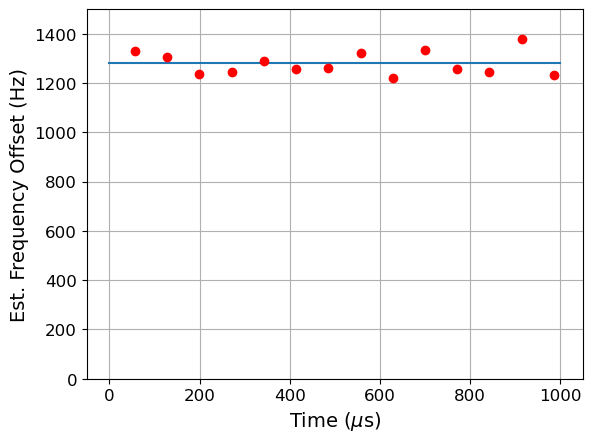

In [30]:
## Estimate the frequency offset
df = np.angle(corr[locs])/N_FFT/2/np.pi*Fs

for n in range(N_syms):
    print('Peak at {:6.1f}us (sample {:d}) - estimated frequency offset: {:6.2f}Hz'.format(
        locs[n]/Fs*1e6, locs[n], df[n]
    ))

avg_df = np.mean(df)
print('==> Average Frequency offset: {:6.1f}Hz'.format(avg_df))

plt.plot([0, 1000], avg_df*np.ones(2))
plt.plot(locs/Fs*1e6, df, 'ro')
plt.grid()

plt.ylim(0, 1500)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Est. Frequency Offset (Hz)')

plt.show()


Estimated frequency offset is consistently near 1280Hz. 

We will us this estimate going forward for frequency correction. 

## OFDM Demodulation

Before proceeding to our search for the PSS, we detour briefly to develop a function for OFDM demodulation. We will need this repeatedly. 

We begin by looking at the specifics of OFDM used by LTE from the standards document.

#### From TS 36.211: 

> **6.12 OFDM baseband signal generation**

> The time-continuous signal $s_l^{(p)}(t)$ on antenna port $p$ in OFDM symbol $l$ in a downlink slot is defined by
$$
s_l^{(p)}(t) = \sum_{k=-\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor}^{-1} a_{k^{(-)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s)) +
\sum_{k=1}^{\lceil N_{RB}^{DL}N_{sc}^{RB}/2 \rceil} a_{k^{(+)},l}^{(p)} \cdot \exp(j2\pi k \Delta f(t-N_{CP,l}T_s))
$$
> for $0 \leq t < (N_{CP,l} + N) \cdot T_s$ where $k^{(-)} = k+ \lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor$ and $k^{(+)}=k+\lfloor N_{RB}^{DL}N_{sc}^{RB}/2 \rfloor -1$. The variable $N$ equals 2048 for $\Delta f = 15 \text{KHz}$.

This language implies that:
1. symbols are mapped to subcarriers in increasing order of frequency. Since most FFT libraries compute FFTs for normalized frequencies from 0 to 1, we must use `fftshift` fater taking the FFT of samples.
2. the subcarrier at zero frequency is left empty.
3. Depending on signal bandwidth, $N_{RB}^{DL} \cdot N_{sc}^{RB}$ are occupied. The number of subcarriers per resource block, $N_{sc}^{RB}$ equals 12 for $\Delta f = 15 \text{KHz}$. For the 10MHz signal on hand, $N_{RB}^{DL}$ equals 50.

The cyclic prefix is specified in the same section; for $\Delta f = 15 \text{KHz}$ the length of the cyclic prefix is 160 for slot number $l=0$ and it is 144 for slots $l=1,\ldots,6$.

According to section 6.2.1 Resource Grid of TS 36.211,
the quantity $N_{RB}^{DL}$ depends on the 
downlink transmission bandwidth configured in the cell and shall fulfil
$$
6 \leq N_{RB}^{DL} \leq 100.
$$ 
The set of allowed values for $N_{RB}^{DL}$ is given by 3GPP TS 36.104. They are $\{6, 15, 25, 50, 75, 100\}$.

The function below an be used to extract the information symbols from a received time domain signal for a given $N_{RB}^{DL}$. The signal is assumed to be frequency corrected before it is passed to this function.


In [46]:
def extract_OFDM(rx_samples, N_RB, N_sc_RB=12):
    """extract information symbols from samples
    
    Inputs:
    rx_samples - length N_FFT vector of received samples; these should be frequency corrected and start AFTER the cyclic prefix
    N_RB - number of resource blocks (BW)
    N_sc_RB - number of subcarriers per resource block (default: 12)

    Returns:
    length N_RB * N_sc_RB frequency domain symbols 
    
    """

    N_FFT = len(rx_samples)
    N_SC = N_RB * N_sc_RB

    # in the occupied BW there are N_SC+1 sub-carriers, N_SC on either side of DC
    # these are the indices of the subcarriers inside the occupied BW
    bw_sc = np.arange(N_FFT//2 - N_SC//2, N_FFT//2 + N_SC//2 + 1)

    # the DC carrier is empty in LTE
    # these N_SC indices skip the DC subcarrier
    active_sc = np.concatenate((np.arange(0, N_SC//2), np.arange(N_SC//2 + 1, N_SC + 1)))

    # FFT
    S = np.fft.fftshift( np.fft.fft( rx_samples ))

    S_bw = S[bw_sc]

    return S_bw[active_sc]

## Locating the Primary Synchronization Signal

The primary synchronization signal, together with the secondary synchronization signal (SSS), allows for precise localization of slot and symbol boundaries. It also facilitates accurate frequency error estimation.

The standards document TS 36.211 contains the following about the genration of the PSS:

> **6.11.1.1 Sequence generation**

> The sequence $d(n)$ used for the primary synchronization signal is generated from a frequency-domain Zadoff-Chu sequence according to
$$
d_u(n) = \begin{cases}
    \exp(-j\frac{\pi u n (n+1)}{63} & \text{ for $n=0,1, \ldots, 30$}\\
    \exp(-j\frac{\pi u (n+1)(n+2)}{63}) & \text{ for $n=31, 32, \ldots 61$}
\end{cases}
$$
> where the Zadoff-Chu root sequence index u is given by Table 6.11.1.1-1.

> **Table 6.11.1.1-1: Root indices for the primary synchronization signal**

<center>

| $N_{ID}^{(2)}$ | Root Index $u$ |
|:--------------:|:--------------:|
| 0              | 25             |
| 1              | 29             |
| 2              | 34             |

</center>

Note, the parameter $N_{ID}^{(2)}$ is part of the cell ID. Depending on which sequence (i.e., which $u$) is found, we obtain part of the cell ID.

The functions below generates the Zadoff-Chu sequence for a given root index $u$.

In [31]:
def fd_zadoff_chu(u):
    """Generate length-63 Zadoff-Chu sequence
    
    Input:
    u - root index

    Returns the length-63 Zadoff-Chu sequence (TS 36.211, section 6.11.1.1)

    Note: this sequence includes the null t the DC subcarrier. That also simplifies the formula
    for computing the sequence
    """
    n = np.arange(63)
    zc = np.exp(-1j*np.pi*u*n*(n+1)/63)
    zc[31] = 0  # This corresponds to the DC subcarrier
    
    return zc

#### Location of the PSS

The standard prescribes where the PSS must be located:

> **6.11.1.2 Mapping to resource elements**

> The mapping of the sequence to resource elements depends on the frame structure. The UE shall not assume that the primary synchronization signal is transmitted on the same antenna port as any of the downlink reference signals. The UE shall not assume that any transmission instance of the primary synchronization signal is transmitted on the same antenna port, or ports, used for any other transmission instance of the primary synchronization signal.

> The sequence $d(n)$ shall be mapped to the resource elements according to 
$$
a_{k,l} =d(n), n=0,\ldots,61 
$$
$$
k = n -31 + \frac{N_{RB}^{DL}N_{sc}^{RB}}{2}
$$


> For frame structure type 1, the primary synchronization signal shall be mapped to the last OFDM symbol in slots 0 and 10.  

> For frame structure type 2, the primary synchronization signal shall be mapped to the third OFDM symbol in subframes 1 and 6.

The mapping to subcarriers $k$ is reflected in the function below that generates the time-domain signal. 

In [33]:
def zadoff_chu(u, N_FFT):
    """Generate time-domain Zadoff-Chu sequence
    
    Input:
    u - root index
    N_FFT - FFT length

    Returns the length-(N_FFT+N_CP) time-domain Zadoff-Chu sequence 
    """
    # generate the FD sequence
    ZC = fd_zadoff_chu(u)

    # make a buffer for IFFT and insert ZC in the center
    buf = np.zeros(N_FFT, dtype=complex)
    buf[N_FFT//2 - 31 : N_FFT//2 + 32] = ZC

    # IFFT
    return np.fft.ifft(np.fft.ifftshift(buf))

According to the standard, for FDD systems (frame structure Type 1) the PSS can only appear in the **last symbol of slots 0 and 10**. Since we were able to locate the symbol boundaries, this greatly reduces the locations we must check.

At this time, we do not know the slot numbers. Hence, we must still look in every slot for the presence of the PSS. 

To locate the PSS, we perform the following steps, starting with the slot that we located starting at sample 12,694.
* locate the samples of the last symbol of the slot
* perform frequency offset correction
* correlate received samples agains each of the three ZC sequences
* check if any of them show significant correlation

In [44]:
## Locate the PSS
sym_start =  locs[0]       # starting sample for first slot
delta_f = avg_df           # frequency offset
SEARCH_WIN = 20            # search a little before and after the estimated symbol location

# Zadoff-Chu sequences
ROOT_INDICES = [25, 29, 34]
ZC = {n: {'u': ROOT_INDICES[n], 'sig': zadoff_chu(ROOT_INDICES[n], N_FFT)} for n in range(3)}
for n in range(3):
    ZC[n]['norm'] = np.linalg.norm(ZC[n]['sig']) # we'll use theseto normalize correlations

DONE = False

n_sym = 0
while not DONE:
    sym_start += N_CP  # skip over the preamble

    # extract the signal for this symbol
    sig = rxf[sym_start - SEARCH_WIN : sym_start + N_FFT + SEARCH_WIN]
    sig_norm = np.linalg.norm(sig[:N_FFT])

    # frequency correction
    sig = sig * np.exp(-2j*np.pi*delta_f*np.arange(len(sig))/Fs)

    # perform correlations between signal and all three ZC sequences
    max_corr = np.zeros(3)
    arg_max_corr = np.zeros(3, dtype=int)
    for n in range(3):
        corr = np.zeros(2*SEARCH_WIN+1)
        zc = ZC[n]['sig']
        zc_norm = ZC[n]['norm']
        for m in range(2*SEARCH_WIN+1):
            # search over search window
            corr[m] = np.abs(np.sum(sig[m:m+N_FFT] * np.conj(zc))) / (zc_norm * sig_norm)

        max_corr[n] = np.max(corr)
        arg_max_corr[n] = np.argmax(corr)

    # check correlation
    if np.max(max_corr) > 0.5:
        # found it!
        DONE = True
        N_id_2 = np.argmax(max_corr)

        # compute the beginning of the slot; this must be either slot 0 or slot 10
        slot_0_or_10_start = sym_start - 6*N_FFT - 7*N_CP - N_CP_extra + (arg_max_corr[N_id_2] - SEARCH_WIN)

        print(
            "Found PSS sequence for N_ID_2 = {:d} in symbol starting at {:d}; correlation: {:4.2f}, offset: {:d}".format(
                N_id_2,
                sym_start - N_CP, 
                max_corr[N_id_2], 
                arg_max_corr[N_id_2] - SEARCH_WIN))
        print('Slot 0 or 10 starts at sample: {:d}'.format(slot_0_or_10_start))
    else:
        # skip forward to next symbol
        print("symbol start: {:d}, max correlation: {:4.2f}".format(sym_start, np.max(max_corr)))
        sym_start += (N_FFT + N_CP)
        n_sym += 1
        if n_sym % 7 == 0:
            sym_start += N_CP_extra

symbol start: 950, max correlation: 0.12
symbol start: 2118, max correlation: 0.08
symbol start: 3286, max correlation: 0.09
symbol start: 4454, max correlation: 0.08
symbol start: 5622, max correlation: 0.12
symbol start: 6790, max correlation: 0.12
symbol start: 7958, max correlation: 0.10
symbol start: 9134, max correlation: 0.15
symbol start: 10302, max correlation: 0.08
symbol start: 11470, max correlation: 0.07
symbol start: 12638, max correlation: 0.13
symbol start: 13806, max correlation: 0.09
symbol start: 14974, max correlation: 0.10
symbol start: 16142, max correlation: 0.07
symbol start: 17318, max correlation: 0.10
symbol start: 18486, max correlation: 0.08
symbol start: 19654, max correlation: 0.11
symbol start: 20822, max correlation: 0.10
symbol start: 21990, max correlation: 0.08
symbol start: 23158, max correlation: 0.09
symbol start: 24326, max correlation: 0.15
symbol start: 25502, max correlation: 0.09
symbol start: 26670, max correlation: 0.11
symbol start: 27838,

Found ZC sequence for N_ID_2 = 0 in slot starting at 125949

So, we found a good match. 

**Note:** If we had downsampled the signal earlier, we would have probably found an earlier strong match.

The offset indicates the position of the best match within the search window. The value -9, indicates that our initial timing estimate is fairly good. The offset estimate is incorporated in the computation of the slot boundary.

We plot the absolute values of the subcarriers for the symbol that carries the PSS below. The PSS is visible in the center of the band - flanked by narrow regions of five empty subcarriers. The symbol appear to contain not only the PSS.

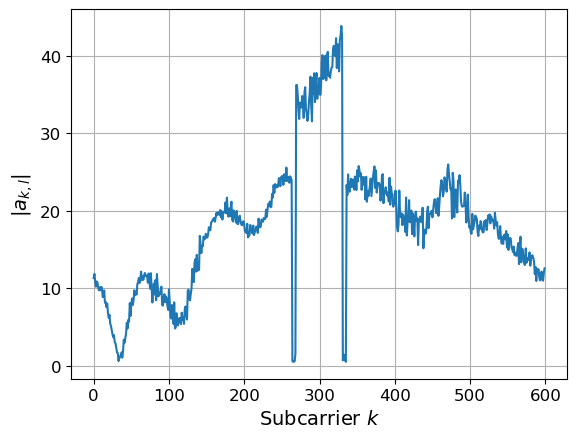

In [47]:
n_start = arg_max_corr[N_id_2]

S = extract_OFDM(sig[n_start:N_FFT+n_start], 50)
plt.plot(np.abs(S))
plt.grid()

plt.xlabel('Subcarrier $k$')
plt.ylabel('$|a_{k,l}|$')

plt.show()

### Refining the frequency offset estimate

In addition to confirming and refining our symbol timing estimate, we can also use the detected PSS for frequency offset estimation.

For that purpose, we measure the phase difference over the two halves of the received PSS multiplied by the conjugate of the ZC sequence, so that the phase of the ZC signal is stripped off.

We have two options for the received samples:
1. we can omit frequency correction prior to correlation; in that case, the frequency offset estimate measures the absolute frequency offset estimate.
2. we can apply frequency offset correction using our current estimate; then, the estimate indicates the residual frequency error - the absolute error is the sum of prior estimate and residual estimate.

Opion 2 is shown below.

In [49]:
## refine the frequency estimate
# grab the samples of the received signal for the symbol that contains the PSS
m = sym_start + arg_max_corr[N_id_2] - SEARCH_WIN
pss_start = m
sig = rxf[m : m+N_FFT] *  np.exp(-2j*np.pi*delta_f*np.arange(N_FFT)/Fs)
# and the correct ZC sequence
zc = ZC[N_id_2]['sig']

# multiply the two
sig_zc = sig * zc.conj()

# and sum each half seprately
pl = np.sum(sig_zc[:N_FFT//2])
pu = np.sum(sig_zc[N_FFT//2:])

# figure out the frequency offset
dfp = np.angle(pu*np.conj(pl))/(2*np.pi*N_FFT//2) * Fs + delta_f

print("Frequency offset estimate from PSS: {:6.2f}".format(dfp))
print("PSS starts at sample {:d}".format(pss_start))

Frequency offset estimate from PSS: 1397.67
PSS starts at sample 286205


This estimate is in-line with the estimates based on cyclic prefix. 

Since the estimates based on the cyclic prefix can be averaged `avg_df`, they appear to be more reliable and will be used going forward.

## Secondary Synchronization Signal

The secondary synchronization signal (SSS) conveys two pieces of information:
1. it provides the remaining bits of the cell id $N_{ID}$, specifically it conveys $N_{ID}^{(1)}$ which takes on values between 0 and 167.
2. it resolves the remaining unertainty about symbol timing.

With respect to timing, recall that LTE signals are orgaized in frames of 10ms duration. 

Frames are divided into 10 subframes of 1ms duration each, these are numbered from 0 to 9.

Each subframe is divided into two slots of duration 0.5ms. Hence, there are 20 slots in each frame.

A PSS is located in the last OFDM symbol of slots 0 and 10. We cannot know if the PSS we detected was located in slot 0 or in slot 10. The SSS resolves this ambiguity ad therefore allows us to find the frame and subframe boundaries as well.

To convey the information about $N_{ID}^{(1)}$ and timing ambiguity, the SSS contains one of $2 \cdot 168 = 336$ possible sequences.

### Construction of the SSS

There are 336 possible SSS sequences that are constructed in a fairly complex process that involves that is spelled out in detail in section 6.11.2.1 of TS 36.211:

1. combinations and cyclic shifts of three different shift-register sequences (M-sequences)
2. the partial cell id $N_{ID}^{(1)}$ informs the cyclic shifts that are applied to these sequences
3. the combination of sequences is different for SSS in the first and second halves of the frame

We begin our construction with the three shift register sequences; these are denoted $\tilde{s}(n)$, $\tilde{c}(n)$, and $\tilde{z}(n)$ in the standard.

In [50]:
def tilde_s():
    "generate shift register sequence tilde_s from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+2] ^ x[n])

    return 1.0 - 2.0*x

In [51]:
def tilde_c():
    "generate shift register sequence tilde_c from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+3] ^ x[n]) 

    return 1.0 - 2.0*x

In [52]:
def tilde_z():
    "generate shift register sequence tilde_z from TS 36.211 section 6.11.2.1"
    x = np.zeros(31, dtype=np.uint8)
    
    # initial loading
    x[4] = 1

    # recursion
    for n in range(26):
        x[n+5] = (x[n+4] ^ x[n+2] ^ x[n+1] ^ x[n]) 

    return 1.0 - 2.0*x

The partial cell ID $N_{ID}^{(1)}$ is encoded in shifts of the above sequences via two intermediate variables $m_0$ and $m_1$. These variables are computed from $N_{ID}^{(1)}$ as follows (see section 6.11.2.1 in TS 36.211):
$$
\begin{align}
m_0 & = m^\prime \mod 31 \\
m_1 & = (m_0 + \lfloor m^\prime/31 \rfloor +1) \mod 31\\
m^\prime &= N_{ID}^{(1)} + q(q+1)/2 \\
q & = \left\lfloor \frac{N_{ID}^{(1)} + q^\prime(q^\prime+1)/2}{30} \right\rfloor \\
q^\prime &= \lfloor N_{ID}^{(1)}/30 \rfloor
\end{align}
$$

The function below computes $m_0$ and $m_1$ from $N_{ID}^{(1)}$.

In [53]:
def m_01(N_ID_1):
    "compute shifts m_0 and m_1 for given N_ID_1"
    q_prime = N_ID_1 // 30
    q = (N_ID_1 + (q_prime * (q_prime + 1)) // 2) // 30
    m_prime = N_ID_1 + (q * (q + 1)) // 2
    m_0 = m_prime % 31
    m_1 = (m_0 + m_prime // 31 + 1) % 31

    return (m_0, m_1)

In [54]:
## a few spot checks against Table 6.11.2.1-1 in TS 36.211
assert (0, 1, ) == m_01(0)
assert (29, 30, ) == m_01(29)
assert (0, 2, ) == m_01(30)
assert (2, 9) == m_01(167)

print("OK")


OK


The final step in the construction of the 336 possible sequences for the SSS is to combine cyclically shifted versions of the shift register sequences. 

The sequences are combined differently for SSS that appear in the first half of a frame (subframes 0 through 4) or the second half (subframes 5 through 9).

The standard specificies that the 62 frequency domain symbols that constitute the SSS are constructed as follows:

The even numbered elements of the SSS are given by:
$$
    d[2n] = \begin{cases}
    s_0^{(m_0)}(n) \cdot c_0(n) & \text{ in subframes $0,1,2,3,4$}\\
    s_1^{(m_1)}(n) \cdot c_0(n) & \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

The odd-numbered elements of the SSS are given by:
$$
    d[2n+1] = \begin{cases}
    s_1^{(m_1)}(n) \cdot c_1(n) \cdot z_1^{m_0}& \text{ in subframes $0,1,2,3,4$}\\
    s_0^{(m_0)}(n) \cdot c_1(n) \cdot z_1^{m_1}& \text{ in subframes $5,6,7,8,9$}
    \end{cases}
$$

Above $s_i^{(m)}$, $c_i$, and $z_i^{(m)}$ are cyclic shifts of the shift register sequences $\tilde{s}$, $\tilde{c}$, and $\tilde{z}$, respectively. The code below provides specific details.

We can now generate the 336 SSS sequences. We store the sequences in a dictionary hat is keyed by an index $n$ computed as $n = N_{ID}^{(1)} + 168\cdot F$, where $F=0$ for the first half-frame and $F=1$ for the second half-frame.

In [55]:
## create a dictionary that contains all 336 SSS sequences
sss_d = {}

# compute the underlying m-sequences just once
tc = tilde_c()
ts = tilde_s()
tz = tilde_z()

# the sequences c0 and c1 don't depende on N_id_1
c0 = np.roll(tc, -N_id_2)
c1 = np.roll(tc, -(N_id_2+3))



for N_id_1 in range(168):
    # loop over N_id_1
    m0, m1 = m_01(N_id_1)
    s0_0 = np.roll(ts, -m0)
    s1_1 = np.roll(ts, -m1)
    z1_0 = np.roll(tz, -(m0 % 8))
    z1_1 = np.roll(tz, -(m1 % 8))

    for F in range(2):
        # loop for first and second half
        ind = N_id_1 + F*168

        d = np.zeros(62)
        if F == 0:
            # first half
            d[0::2] = s0_0 * c0
            d[1::2] = s1_1 * c1 * z1_0
        elif F == 1:
            # second half
            d[0::2] = s1_1 * c0
            d[1::2] = s0_0 * c1 * z1_1
        else:
            raise ValueError("invald value for F ({:d})".format(F))

        # store the sequence
        sss_d[ind] = {'N_id_1': N_id_1, 'F': F, 'seq': d}
    

### Matching the SSS

According to section 6.11.2.2 of TS 36.211, the SSS is located in the OFDM symbol that immediately precedes the PSS, i.e., in the second to last symbol of slot 0 and slot 10. Hence, after locating the SSS the samples for the PSS are easy to find.

For computational efficiency, it is much easier to correlate in the frequency domain, since the sequence length is only 62 - not 2048.

However, to perform matching in the frequency domain we must not only frequency correct the samples holding the SSS but also **equalize** the signal. Otherwise, the amplitude and phase distortion introduced by the channel corrupts the correlation.

Fortunately, euqalization is straightforward in OFDM. The following steps will be performed:
1. locate the samples that hold the two consecutive OFDM symbols for SSS and PSS; since we located the PSS accurately above, this is easily accomplished,
2. frequency correct both of these symbols using the frequency offset estimate from the PSS (variable `dfp`); performing frequency correction over both symbols ensures that the correction is continuous in phase,
3. estimate the frequency response of the channel from the PSS; this is as simple as multiplying the frequency domain PSS by the conjugate of the appropriate Zadoff-Chu sequence,
4. equalize the SSS via the estimated frequency response; this involves dividing the frequency domain samples by the estimated frequency response.

After these steps, we can perform matching in the frequency domain.

#### Extract and frequency correct  SSS and PSS symbols

We located the first sample of the PSS above (variable `pss_start`). From there, we can work backwards to find the first sample of the SSS.

From the start of the SSS, we can extract the samples for the OFDM symbols holding both PSS and SSS (excluding the CP of the SSS).

Finally, we perform frequency correction over these samples.

In [61]:
# find the start of the SSS
sss_start = pss_start - (N_FFT + N_CP)

# extract samples for SSS and PSS
N = 2*N_FFT + N_CP
ss_sig = rxf[sss_start : sss_start+N]

# frequency correct
ss_sig = ss_sig * np.exp(-2j * np.pi * avg_df * np.arange(len(ss_sig)) / Fs)

# split the two signals, discard CP before PSS
sss_sig = ss_sig[:N_FFT]
pss_sig = ss_sig[-N_FFT:]

#### Channel Estimation using PSS

The final piece of information to be extracted from the PSS is an estimate of the frequency response of the channel. The frequency response is induced by the multi-path propagation of the signal.

The frequency response alters the magnitude and phase of the information symbols on each subcarrier.

We want to process the secondary synchronization signal SSS in the frequency domain. To do so, we must be able to remove the distortion from the channel's frequency response. This is called frequency domain equalization.

To estimate the frequency response of the channel, we:
1. transform the PSS signal to the frequency domain and extract the 62 subcarriers holding the Zadoff-Chu sequence,
2. muliply these 62 subcarriers by the conjugate of the Zadoff-Chu sequence for the $N_{ID}^{(2)}$ we determined ($N_{ID}^{(2)}=2$).

In [62]:
## channel estimation via PSS
pss_fd = extract_OFDM(pss_sig, 50) # all 600 subcarriers

# get the center 62 subcarriers
N_sc = 50 * 12
pss_fd = pss_fd[N_sc//2 - 31 : N_sc//2 + 31]

# multiply by conjugate of Zadoff-Chu sequence
zc = fd_zadoff_chu(ROOT_INDICES[N_id_2])
zc = np.concatenate( (zc[:31], zc[32:]) ) # strip out the zero in ZC sequence
H_est = pss_fd * np.conj( zc )

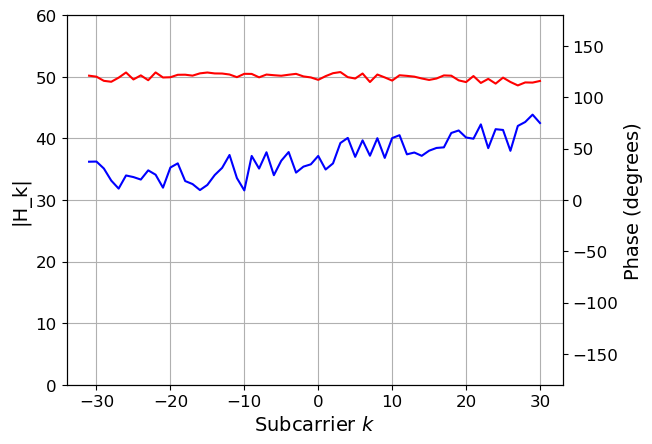

In [63]:
## plot the magnitude and phase of the channel estimate
fig, ax = plt.subplots()
# magnitude
ax.plot(np.arange(-31, 31), np.abs(H_est), 'b-', label='Magnitude')
plt.grid()

ax.set_xlabel('Subcarrier $k$')
ax.set_ylabel('|H_k|')
ax.set_ylim(0, 60)

# phase
ax2 = ax.twinx()
ax2.plot(np.arange(-31, 31), np.angle(H_est) * 180/np.pi, 'r-', label="Phase")
ax2.set_ylabel('Phase (degrees)')
ax2.set_ylim(-180, 180)

plt.show()

Both the magnitude and the phase are fairly constant over the bandwidth occupied by the PSS. This is indicative of very little multipath.

#### Equalize the SSS

We can now equalize the SSS in the frequency domain.

First, the subcarriers that contain the SSS must be extracted.

Then, these subcarriers aare divided by the estimated frequency response.

The resulting samples should show a BPSK constellation (modulation of the SSS).

In [64]:
## Equalize the SSS
sss_fd = extract_OFDM(sss_sig, 50) # all 600 subcarriers

# get the center 62 subcarriers
N_sc = 50 * 12
sss_fd = sss_fd[N_sc//2 - 31 : N_sc//2 + 31]

# equalize
sss_fd_eq = sss_fd / H_est

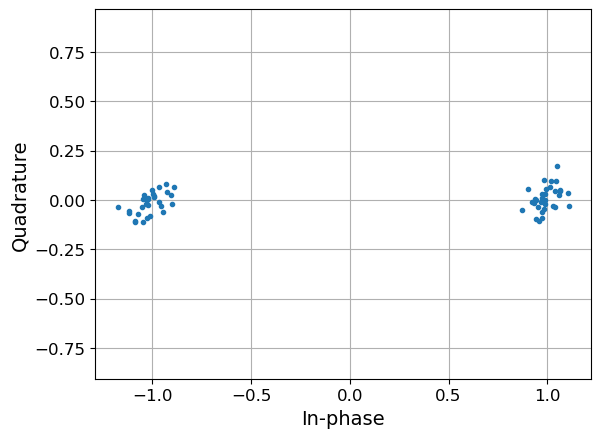

In [65]:
## plot the equalized SSS  symbols
plt.plot(sss_fd_eq.real, sss_fd_eq.imag, '.')
plt.grid()
plt.axis('equal')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')

plt.show()

The equalized samples show a very clean BPSK constellation. It will not be difficult to find the matching SSS sequence.

#### Find the matching SSS sequence

The final processing step for the SSS is to find which of the 336 possible SSS sequences matches the equalized frequency domain samples.

For that purpose, we correlate the equalized samples against each of the possible sequences and dtermine which one matches best.

In [66]:
corr = np.zeros(336)

for ind, d in sss_d.items():
    seq = d['seq']

    # correlation; only look at real part since we equalized
    corr[ind] = np.sum(sss_fd_eq.real * seq)

ind_max = np.argmax(corr)
N_id_1 = sss_d[ind_max]['N_id_1']
F = sss_d[ind_max]['F']

print("Best match for N_id_1 = {:d} in {:s} half-frame (correlation coefficient {:4.2f})".format( N_id_1,
'first' if F==0 else 'second',
corr[ind_max]/62))

Best match for N_id_1 = 108 in first half-frame (correlation coefficient 1.00)


#### Decoding the Phycal Cell ID (PCI)

The two partial cell IDs $N_{ID}^{(1)}$ and $N_{ID}^{(2)}$ must be combined to yield the phycal cell id (PCI) $N_{ID}^{cell}$. Section 6.11 of TS 36.211 states:

> **6.11 Synchronization Signals**

> There are 504 unique physical-layer cell identities. The physical-layer cell identities are grouped into 168 unique physical-layer cell-identity groups, each group containing three unique identities. The grouping is such that each physical-layer cell identity is part of one and only one physical-layer cell-identity group. A physical-layer cell identity
$N_{ID}^{cell} = 3N_{ID}^{(1)} + N_{ID}^{(2)}$ is thus uniquely defined by a number $N_{ID}^{(1)}$ in the range of 0 to 167, representing the physical-layer
cell-identity group, and a number $N_{ID}^{(2)}$ in the range of 0 to 2, representing the physical-layer identity within the
physical-layer cell-identity group.


We compute the PCI indicated by this signal and also compute the location of the next full frame (after the detected PSS) in the received samples.

In [67]:
print("PCI: {:d}".format(3*N_id_1 + N_id_2))
N_ID_cell = 3*N_id_1 + N_id_2
# from pss_start, add one symbol duration (w/o CP) and either 9 or 19 slot durations (each slot is 0.5ms)
print("Next frame starts at or near sample {:d}".format(pss_start + N_FFT + (19-10*F) * int(Fs * 0.5e-3)))
print("Current frame starts at or near sample {:d}".format(pss_start + N_FFT - (1 + 10*F) * int(Fs * 0.5e-3)))

# pick one of these to continue processing
# frame_start = pss_start + N_FFT + (19 - 10*F) * int(Fs * 0.5e-3)  # next frame
frame_start = pss_start + N_FFT - (1 + 10*F) * int(Fs * 0.5e-3)   # current frame

PCI: 324
Next frame starts at or near sample 433149
Current frame starts at or near sample 279549


## Task: Decode the MIB

With the frame boundaries established, the next task is to extract the MIB. 

### Pull out samples needed for MIB

The MIB is always transmitted on the PBCH (physical broadcast channel) wihich is found:
* in the first four symbols of the second slot in a frame (for both FDD and TDD)
* on 6 resource blocks (RB), i.e., 72 subcarriers centered at the DC carrier.

The MIB is repeated on four consecutive subframes (for additional error robustness). Hence, the MIB information changes at most every four frames (40ms). It should suffice to process just one such repetition.

To start MIB processing, we first collect the samples for the four blocks containing the PBCH, perform frequency correction, and then convert to the frequency domain.  

In [88]:
## locate the samples that carry the MIB
# advance to start of slot 1 in the frame
slot_start = frame_start + 7 * (N_FFT + N_CP) + 16 // (2048 // N_FFT)

# number of samples in first four symbols including CP, recall that symbol 0 has the longer CP
n_pbch = 4 * (N_FFT + N_CP) + 16 // (2048 // N_FFT)

# extract the samples for the PBCH
pbch_sig = rxf[slot_start : slot_start +n_pbch]

# and frequency correct
pbch_sig = pbch_sig * np.exp(-2j * np.pi * avg_df * np.arange(len(pbch_sig)) / Fs)


In [89]:
## convert the four PBCH symbols to frequency domain
L_PBCH = 4   # number of symbols for PBCH
K_PBCH = 6   # number of RBs for PBCH
PBCH = np.zeros((L_PBCH, K_PBCH*12), dtype=complex)  # 12 subcarriers per RB

sym_start = 0

for l in range(L_PBCH):
    # skip over the CP
    sym_start += N_CP
    if l == 0:
        sym_start += 16 // (2048 // N_FFT) # longer CP for first symbol

    # FFT the next N_FFT samples
    PBCH[l, :] = extract_OFDM(pbch_sig[sym_start : sym_start + N_FFT], K_PBCH) # only the center 6 RB are needed

    # advance to next symbol
    sym_start += N_FFT

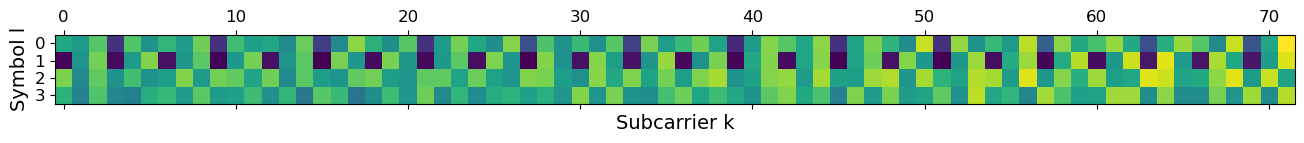

In [90]:
## check: plot the magnitude of the PBCH grid; we might see patterns that indicate CRS locations
plt.matshow(np.abs(PBCH))
plt.xlabel('Subcarrier k')
plt.ylabel('Symbol l')

plt.show()

This looks good! The darker areas indicate unused CRS locations.

## How is the PBCH constructed from the MIB

The MIB carries 24 bits of information which we seek to recover. These bits are processed as follows to produce the $ 4 \cdot 72 = 288$ OFDM symbols we saw above:

1. **CRC** a 16-bit CRC is appanded; that expands the number of bits to 40. (TS 36.212, sections 5.3.1.1 and 5.1.1)
2. **FEC** a rate 1/3 convolutional code is applied to produce 120 coded bits. (TS 36.212, sections 5.3.1.2 and 5.1.3.1)
3. **Rate Matching** the coded bits are permuted, interleaved, and repeated 16 times to yield $16 \cdot 120 = 1920$ coded bits (TS 36.212, sections 5.3.1.3 and 5.1.4.2)
4. **Scrambling** the coded bits are multiplied by a pseudo-random binary sequence to produce 1920 scrambled bits (TS 36.212, section 6.6.1)
5. **Modulation** the scrambled bits are mapped to $1920/2=960$ QPSK symbols (TS 36.212, sections 6.6.2 and 7.1)
6. **Layer Mapping and Precoding** A space-time code is applied to provide transmit diversity. This involves generating signals for multiple antennas (layers). The mapping depnds on the number of antennas (1, 2, or 4) - which is unknown at this point (signaled by MIB). Hence, all three possibilities should be attempted. This does not change the number of symbols. (TS 36.211, sections 6.6.1 and 6.3.4.1 or 6.3.4.3 depending on number of antennas)
7. The 960 symbols are split over four consecutive frames (240 symbols per frame) and placed in resource elements that are not occupied by CRS (reference signals). There are 48 resource elements occupied by CRS in the area occupied by the PBCH for a total of $240+48=288$ resource elements. (TS 36.211, section 6.6.4)

To recover the MIB we must process the PBCH in the reverse order of these steps:

1. **CRS** we must extract the cell-specific reference signals from the received signal and form estimates of the channel's frequency responses from each transmit antenna to the receiver.
2. **Transmit Diversity Combining/Equalization** Based on the channel estimates obtained via the CRS, the received signal must be equalized to compensate for the frequecy response. In the case of multiple antennas, transmit diversity combining must be applied. At the end of this process, we should have clean QPSK symbols.
3. **Demodulation** The QPSK symbols are demodulated to form bit decisions (either soft or hard decisions).
4. **Descrambing** The bit decisions are descrambled.
5. **Rate Matching** The re-ordering and repetitions applied during rate-matching are undone to yield 120 inputs for the FEC decoder.
6. **Decoding** The bit decisions are decoded using a Viterbi Decoder.
7. **Check CRC** Verify the CRC; this also confirms the number of transmit antennas.

## Cell-Specific reference sequences (CRS)

CRS are used to estimate the channel between transmit antennas and the receivers. They are located throughout the resource grid as specified in TS 36.211 section 6.10.1. 



### CRS Sequence Generation

The complex symbols used as the CRS signal are generated as specified in TS 36.211, section 6.10.1.1

> The reference-signal sequence $r_{l,n_s}(m)$ is defined by
$$
r_{l,n_s}(m)= \frac{1}{\sqrt{2}} (1−2c(2m))+ j \frac{1}{\sqrt{2}} (1−2⋅c(2m+1)), \quad m=0,1,\ldots,2N_{RB}^{max,DL} −1
$$
>where $n_s$ is the slot number within a radio frame and $l$ is the OFDM symbol number within the slot. The pseudo-
random sequence $c(i)$ is defined in clause 7.2. The pseudo-random sequence generator shall be initialised with 
$c_{init} =2^{10} \cdot (7⋅(n_s'+1)+l+1)\cdot(2⋅N_{ID}^{cell} +1)+2\cdot N_{ID}^{cell} + N_{CP}$ at the start of each OFDM symbol where
$$
n_s' = \begin{cases}
10 \cdot \lfloor n_s/10\rfloor  + n_s \mod 2 & \text{for framestructure type 3 when the CRS is part of a DRS}\\
n_s & \text{otherwise}
\end{cases}
$$
$$
N_{CP} =
\begin{cases}
1 & \text{for normal CP}\\
0 & \text{for extended CP}
\end{cases}
$$

The reference signals $r_{l,n_s}(m)$ are generated from pseudo-random binary sequences (TS 36.211, section 7.2):

> Pseudo-random sequences are defined by a length-31 Gold sequence. The output sequence $c(n)$ of length $M_{PN}$ , where $n=0,1,\ldots,M_{PN} −1$,is defined by
\begin{align*}
c(n) & = (x_1 (n + N_C ) + x_2 (n + N_C )) \mod 2\\
x_1 (n + 31) & = (x_1 (n + 3) + x_1 (n)) \mod 2\\
x_2 (n + 31) & = (x_2 (n + 3) + x_2 (n + 2) + x_2 (n +1) + x_2 (n)) \mod 2
\end{align*}
where $N+C =1600$ and the first m-sequence shall be initialized with $x_1(0)=1$, $x_1(n)=0$, $n=1,2,\ldots,30$.The initialization
of the second m-sequence is denoted by $c_{init} = \sum_{i=0}^{30} x_2(i) \cdot 2^i$ with the value depending on the application of the
sequence.

*Note:* This generator is also used in 5G for generating demodulation reference signals (DMRS).

The functions below provide a (not very efficient) implementation of the generator for these sequences. 

In [91]:
# quick and dirty implementation of pseudo-random sequence c(n)
# M: PN sequence Length
# From TS 36.211 Section 7.2
def naive_x1(M, Nc):
    """Generate sequence x1"""
    x1 = np.zeros(M + Nc, dtype=np.uint8)

    # initialize
    x1[0] = 1
    x1[1:30] = 0

    # compute
    for n in range(31, M + Nc):
        x1[n] = x1[n - 31] ^ x1[n - 28]

    return x1[Nc:]


# c_init is the seed value
def naive_x2(M, c_init, Nc):
    """Generate sequence x2"""
    x2 = np.zeros(M + Nc, dtype=np.uint8)

    # initialize
    for k in range(31):
        x2[k] = (c_init & (1 << k)) >> k

    # compute
    for n in range(31, M + Nc):
        x2[n] = x2[n - 31] ^ x2[n - 30] ^ x2[n - 29] ^ x2[n - 28]

    return x2[Nc:]


def naive_cn(M, c_init, Nc=1600):
    """Generate samples of pseudo-random sequence"""
    return naive_x1(M, Nc) ^ naive_x2(M, c_init, Nc)


The function below generates reference signals $r_{l,n_s}(m)$ for a given slot number $n_s$, slot number $l$, cell id $N_{ID}^{cell}$ and indicator for the length of the cyclic prefix. 

These sequence are of length $N_{RB}^{max,DL} = 110$ (TS 36.211, section 6.2.1).

In [92]:
N_RB_max_DL = 110

def crs_seq(ns, l, N_id_cell, N_CP_ind=1):
    """generate CRS sequence for CRS
    
    Parameters:
    ns - slot number
    l - symbol number
    N_id_cell - cell ID
    N_CP_ind - equals 0 for normal CP (default), 1 for extended CP
    """
    # generate the pseudo-rmdom sequence c(n)
    c_init = (((7 * (ns + 1) + l+ 1) * (2 * N_id_cell + 1) )<< 10) + 2*N_id_cell + N_CP_ind

    c_n = naive_cn(4*N_RB_max_DL, c_init)

    return np.sqrt(0.5) * ( (1. - 2.*c_n[0::2]) + 1j*(1. - 2.*c_n[1::2]) ) 

### Where do the CRS symbols appear

TS 36.211, section 6.10.1.2 specifies the mapping of CRS symbols to resource elements:

>The reference signal sequence $r_l,n_s(m)$ shall be mapped to complex-valued modulation symbols a_{k,l}^{(p)} used as reference
symbols for antenna port $p$ in slot $n_s$ according to
$$
a_{k,l}^{(p)}=r_{l,n_s}(m')
$$
>where
$$
k = 6m+(\nu+\nu_{shift}) \mod 6
$$
$$
l = \begin{cases}
0, N_{symb}^{DL} - 3 & \text{ if $p \in \{0,1\}$}\\
1 & \text{ if $p \in \{2,3\}$}\\
\end{cases}
$$
$$
m=0,1,...,2 \cdot N_{RB}^{DL} −1
$$
$$
m'=m+N_{RB}^{max,DL} −N_{RB}^{DL}
$$
>The variables $\nu$ and $\nu_{shift}$
define the position in the frequency domain for the different reference signals where $\nu$ is
$$
\nu = 
\begin{cases}
0 & \text{if $p=0$ and $l=0$}\\
3 & \text{if $p=0$ and $l\neq 0$}\\
3 & \text{if $p=1$ and $l=0$}\\
0 & \text{if $p=1$ and $l\neq 0$}\\
3 \cdot (n_s \mod 2) & \text{if $p=2$}\\
3 + 3 \cdot (n_s \mod 2) & \text{if $p=3$}
\end{cases}
$$
>The cell-specific frequency shift is given by $\nu_{shift} = N_{ID}^{cell} \mod 6$.

>Resource elements (k,l) used for transmission of cell-specific reference signals on any of the antenna ports in a slot shall not be used for any transmission on any other antenna port in the same slot and set to zero.

**Notes:**
* CRS sequences are transmitted on all active antennas.
* The CRS locations for different antennas do not overlap - when a CRS symbol is sent, only one antenna is active.
* Each antenna's CRS signal appears on every sixth subcarrier
* Location and content of CRS is cell specific
* With respect to the MIB, relevant CRS locations are in the first symbol (for antenas 0 and 1) or the second symbol (antennas 2 and 3).

The function below generates the CRS symbols and the corresponding frequency locations $k$ where these symbols appear for all four antennas.

In [93]:
def crs_syms_and_k(N_RB, p, l, ns, N_id_cell, N_CP_ind=1, N_symb_DL=7):
    """compute the CRS symbols and their locations for given symbol and antenna"""
    nu = -1
    if p == 0:
        if l == 0:
            nu = 0
        elif l == N_symb_DL-3:
            nu = 3
    if p == 1:
        if l == 0:
            nu = 3
        elif l == N_symb_DL-3:
            nu = 0
    if p == 2 and l == 1:
        nu = 3 * (ns % 2)
    if p == 3 and l == 1:
        nu = 3 + 3 * (ns % 2)

    # if nu is still -1 then there is no CRS for this p and l
    if nu == -1:
        return None, None

    # generate the CRS
    nu_shift = N_id_cell % 6
    m = np.arange(2*N_RB)
    # these are the subcarrier locations
    k = 6*m + (nu + nu_shift) % 6

    # this generates the corresponding symbols
    mm = m + N_RB_max_DL - N_RB
    rr = crs_seq(ns, l, N_id_cell, N_CP_ind)
    crs_syms = rr[mm]

    return k, crs_syms

### Estimating Frequency Responses

We now know where CRS symbols are located and what their values should be. With this information and the PBCH block computed earlier, we can now form estimates of the frequency response.

Over the duration of the MIB, We can obtain a frequency response estimate for every sixth subcarrier for each of (possibly four antennas).

In [94]:
## obtain frequency estimates at CRS locations
est_H = {}
for p in range(4):
    crc_d = {}
    l = 0
    if p > 1:
        l = 1

    kk, syms = crs_syms_and_k(K_PBCH, p, l, 1, N_ID_cell, 1, 7)
    crc_d['k'] = kk
    crc_d['syms'] = syms

    # form estimate by stripping of the CRS symbol from received resource element
    H_est = PBCH[l, kk] * np.conj(syms)
    crc_d['H_est'] = H_est

    est_H[p] = crc_d

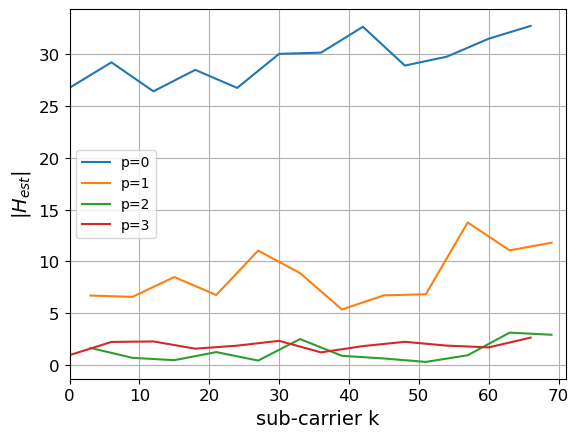

In [95]:
## plot the results: 
# plot the magnitude of the estimated frequency responses over subcarrier numbers
for p in range(4):
    crc_d = est_H[p]
    plt.plot(crc_d['k'], np.abs(crc_d['H_est']), label="p={:d}".format(p))

plt.grid()
plt.xlim(0, 71)

plt.xlabel('sub-carrier k')
plt.ylabel('$|H_{est}|$')

plt.legend()
plt.show()

It looks like antenna 0 and (possibly) antenna 1 are transmitting CRS signals. The signal from the other two antennas is likely just noise.

We'll look at the phases of the estimates to confirm; an erratic phase is associated with just noise.

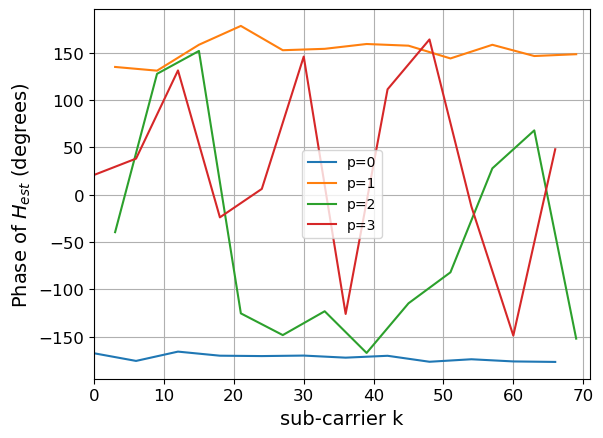

In [96]:
## plot the results: 
# plot the phase of the estimated frequency responses over subcarrier numbers
for p in range(4):
    crc_d = est_H[p]
    plt.plot(crc_d['k'], 180/np.pi * np.angle(crc_d['H_est']), label="p={:d}".format(p))

plt.grid()
plt.xlim(0, 71)

plt.xlabel('sub-carrier k')
plt.ylabel('Phase of $H_{est}$ (degrees)')

plt.legend()
plt.show()

As suggested by the magnitudes, it appears that only two antennas are active.

### Interpolate Frequency Response Estimates

To conclude processing of the CRS, we interpolate the frequency response estimate to all 72 subcarriers that hold the PBCH. To do so, we use the closest (in $k$) estimate.

In [97]:
## interpolate the frequency response estimates
H_PBCH = np.zeros_like(PBCH)
for p in range(4):
    crc_d = est_H[p]
    k_est = crc_d['k']
    H_est = crc_d['H_est']

    for k in range(K_PBCH * 12):
        ind_k = np.argmin(np.abs(k - k_est))
        H_PBCH[p, k] = H_est[ind_k]

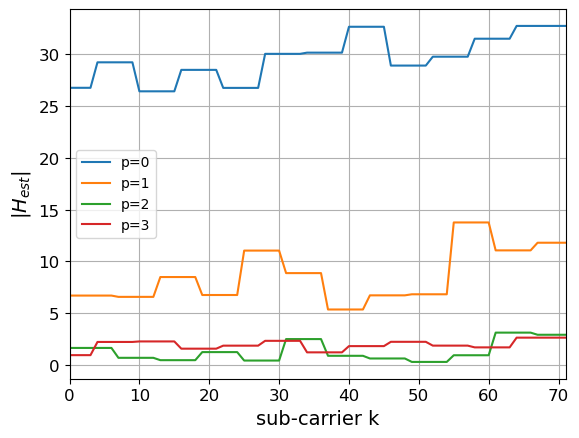

In [98]:
## check that this worked
for p in range(4):
    plt.plot(np.arange(72), np.abs(H_PBCH[p,:]), label="p={:d}".format(p))

plt.grid()
plt.xlim(0, 71)

plt.xlabel('sub-carrier k')
plt.ylabel('$|H_{est}|$')

plt.legend()
plt.show()

### Extract PBCH Symbols

In preparation for the next processing steps, we extract the PBCH information symbols - discarding CRS symbols. 

TS 36.211, section 6.6.4 specifies that any resource element that could be used for CRS must be skipped. Otherwise, PBCH symbols are mapped to resource elements in frequency-first order.

Along with the symbols we also store the estimates of the freuency response.

In [99]:
## Extract PBCH information symbols
# storage for symbols and H estimates
PBCH_syms = np.zeros(240, dtype=complex)
H_est = np.zeros((4, 240), dtype=complex)

# which subcarriers to skip depends on the cell id
nu_shift = N_ID_cell % 6
skip_set = {nu_shift, (nu_shift+3) % 6}

n = 0
for l in range(4):
    for k in range(K_PBCH * 12):
        # skip this?
        if l < 2 and (k % 6) in skip_set:
            continue

        PBCH_syms[n] = PBCH[l, k]
        H_est[:, n] = H_PBCH[:, k]

        n = n+1

## Transmit Diversity Combining

We will process the signal under the assumption that **two** transmit antennas were used. In that case, information is encoded with a Space-Time Code (STC) that provides transmit diversity by utilizing propagation paths from two different antennas. This code is known as an *Alamouti* code.

If only a single antenna were used, then no space-time code is applied. With four antennas, a similar STC is used. 

The STC for two (and four antennas) is described in section 6.3.4.3 of TS 36.211. Below is a more concise description of the code in terms of complex symbols. The code is 

The code transmits two consecutive symbols $x[2n]$ and $x[2n+1]$ simultaneously over two antennas using two transmit symbols $y^{(p)}[2n]$ and $y^{(p)}[2n+1]$ for each antenna $p$. The transmited symbols are constructed as follows:
\begin{align*}
y^{(0)}[2n] &= x[2n] & \quad & y^{(0)}[2n+1] & = x[2n+1] \\
y^{(1)}[2n] &= -x^*[2n+1] & \quad & y^{(1)}[2n+1] & = x^*[2n] 
\end{align*}
Note that each symbol is sent (in some form) on each antenna and for each $n$.

The received signal will be the superposition of the signals from the two antennas. If we denote by $H_p$ the frequency response from the $p$-th antenna to the receiver then the received signal is:
$$
r[n] = H_0 \cdot  y^{(0)}[n] + H_1 \cdot  y^{(1)}[n] + N_n.
$$

It can be shown, that optimal estimates for the symbols $x[n]$ are given by:
$$
x[2n] = \frac{1}{|H_0|^2 + |H_1|^2} \cdot (H_0^* \cdot r[2n] + H_1 \cdot r^*[2n+1])
$$
and 
$$
x[2n+1] = \frac{1}{|H_0|^2 + |H_1|^2} \cdot (-H_1^* \cdot r[2n] + H_0 \cdot r^*[2n+1])^*
$$
Note that this operation performs both equalization and combining of the signals from the two antennas.

The function below performs the combining operation for two received symbols and the correspond frequency responses.

In [100]:
def Alamouti_combine(r0, r1, H0, H1):
    "perform combing of two symbols for an Alamouti STC"
    scale = abs(H0)**2 + abs(H1)**2

    x0 =  (H0.conjugate() * r0 + H1 * r1.conjugate()) / scale
    x1c = (-H1.conjugate() * r0 + H0 * r1.conjugate()) /scale

    return x0, x1c.conjugate()

In [101]:
# Quick test
# symbols
x0 = 1 - 1j
x1 = 3 + 2j

# STC
y00 = x0
y01 = x1
y10 = -x1.conjugate()
y11 = x0.conjugate()

# Channel
H0 = np.exp(1j*np.pi/7)
H1 = -1j
r0 = H0 * y00 + H1 * y10
r1 = H0 * y01 + H1 * y11

#decode; we should get x0, x1 back
Alamouti_combine(r0, r1, H0, H1)

((0.9999999999999998-1j), (3+2j))

With the function for Alamouti combining in Hand, we can process the received PBCH symbols.

In [102]:
## transmit diversity combining
PBCH_x = np.zeros_like(PBCH_syms)

for n in range(len(PBCH_syms) // 2):
    PBCH_x[2*n], PBCH_x[2*n+1] = Alamouti_combine(PBCH_syms[2*n], PBCH_syms[2*n+1], H_est[0, 2*n], H_est[1, 2*n])
    

To check that the combining was successful, we plot the received constellation. This should be a fairly clean QPSK constellation.

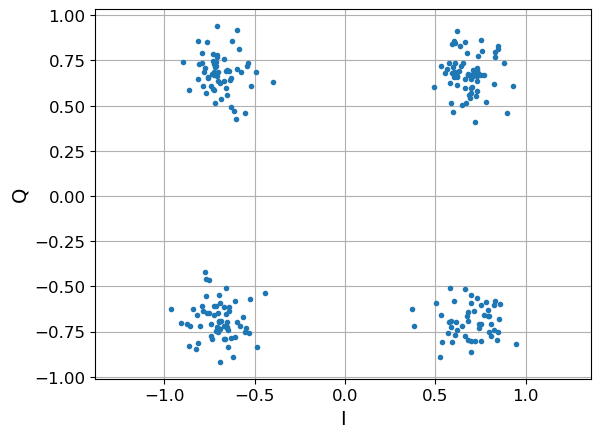

In [103]:
## plot the received constellation
plt.plot(PBCH_x.real, PBCH_x.imag, '.')
plt.grid()
plt.axis('equal')
plt.xlabel('I')
plt.ylabel('Q')

plt.show()

## Demodulation

In the next step, we demodulate the QPSK symbols. Either soft or hard decision decoding is possible. Since the received signal appears very clean, we settle for hard decision decoding.

According to section 7.1.2 in TS 36.211, the QPSK modulator maps the first modulated bit to the polaruty of the I-channel and the second bit to the Q-channel.

In [104]:
def qpsk_demodulate(x):
    "QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x), dtype=np.uint8)

    for n in range(len(x)):
        b[2*n] = 0 if np.real(x[n]) > 0 else 1
        b[2*n+1] = 0 if np.imag(x[n]) > 0 else 1

    return b

In [105]:
PBCH_scrambled_bits = qpsk_demodulate(PBCH_x)

Below is the soft-decision demodulator for QPSK. Rather than quantizing decisions to +1 or -1, we retain magnitude information for each bit.

In [106]:
def qpsk_demodulate_soft(x):
    "Soft decision QPSK demodulate a sequence of observation"
    b = np.zeros(2*len(x))

    b[0::2] = np.sqrt(2)*np.real(x)
    b[1::2] = np.sqrt(2)*np.imag(x)

    return b

In [107]:
PBCH_scrambled_bits_soft = qpsk_demodulate_soft(PBCH_x)

## Scrambling

Section 6.6.1 of TS 36.211 specifies that the FEC encoded and rate-matched MIB is to be scrambled with a pseudo-random sequence.

>The block of bits $b(0),\ldots,b(M_{bit} −1)$ , where $M_{bit}$, the number of bits transmitted on the physical broadcast channel,
equals 1920 for normal cyclic prefix and 1728 for extended cyclic prefix, shall be scrambled with a cell-specific
sequence prior to modulation, resulting in a block of scrambled bits $\tilde{b}(0),\ldots,\tilde{b}(M_{bit} −1)$ according to 
$$
\tilde{b}(i) = (b(i) + c(i)) \mod 2
$$
>where the scrambling sequence $c(i)$ is given by clause 7.2. The scrambling sequence shall be initialised with
$c_{init} = N_{ID}^{cell}$ in each radio frame fulfilling $n_f \mod 4 = 0$.

The scrambling sequence is generated from the same pseudo-random genarator as the CRS (see `naive_cn` above.)

A complication arises because we observ only a quarther of the 1920 bits that represent the MIB in each frame. So, the bits we're processing here could be scrambled by anny any of four possible segments of the scrambling sequence.

We have to try (and carry forward) all four possibilities. This will ultimately reveal which segment we observed and therefore which of the four possible frames carrying identical MIB information this is. This also fills in the lowest two bits of the system frame number.

The code below descrambles the demodulated bits with each of the possible four segments.

In [110]:
## descramble
# First generate the entire scrambling sequence
c = naive_cn(1920, N_ID_cell)
N_bits = len(PBCH_scrambled_bits)  # 480 - a quarter of all bits

PBCH_bits = np.zeros((4, N_bits), dtype=np.uint8)
PBCH_bits_soft = np.zeros((4, N_bits))
for n in range(4):
    PBCH_bits[n,:] = PBCH_scrambled_bits ^ c[n*N_bits : (n+1)*N_bits]
    PBCH_bits_soft[n,:] = PBCH_scrambled_bits_soft * (1. - 2. * c[n*N_bits : (n+1)*N_bits])

Only one of the four segments is correct. For the correctly de-scrambled sequence the bit pattern will repeat every 120 bits.

In [111]:
PBCH_bits[:, 0:10], PBCH_bits[:, 120:130]

(array([[1, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 1]], dtype=uint8),
 array([[1, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 0, 1, 1, 1]], dtype=uint8))

In [114]:
PBCH_bits_soft[:, 0:10] - PBCH_bits_soft[:, 120:130]

array([[ 0.004281  ,  0.017501  ,  0.17046508,  1.92595775,  1.82221332,
         1.95717198,  2.0254892 , -2.05458171,  1.80166182,  0.20601228],
       [ 0.004281  , -1.95385538,  0.17046508, -1.92595775,  0.18429222,
        -0.08275764, -2.0254892 , -2.05458171,  0.24757923, -0.20601228],
       [ 0.004281  , -0.017501  ,  0.17046508, -0.2731699 ,  0.18429222,
         0.08275764, -0.31573677, -0.19424503,  0.24757923, -0.20601228],
       [-2.05587607,  1.95385538, -2.27725264,  1.92595775, -0.18429222,
        -1.95717198, -0.31573677,  2.05458171,  1.80166182, -0.20601228]])

It appears that the third scrambling sequence segment is the one that matches. We will still carry all four possibilities forward.

## Rate Matching

The FEC coded bits are interleaved, permuted and rate matched as specified in section 5.1.4.2 of TS 36.212. Figure 5.1.4-2 from TS 36.212 is replicated below.

![Rate Matching](RateMatching.png)

First three coded blocks of 40 bits each from the convolutional coder are interleaved individually using a subblock interleaver specified in section 5.1.4.2.1 of TS 36.212. 

These blocks are concatenated and then repeated until 1920 bits have been generated.
Specifically, the coded and interleaved blocks - consisting of 120 bits -  are simply repeated 16 times to generate 1920 bits. A quarter of these bits (480) appear in a single PBCH block. Put differently, in a single PBCH the coded and interleaved bits are repeated four times.

For recovering the bits constituting the MIB, we only need 120 coded bits. To reduce the 480 bits in the PBCH, we have two options:
1. Simply retain just the first 120 demodulated bits (hard or soft)
2. Combine the four repettions (by averaging); this is particularly simple for the soft decisions. Averaging improves the SNR by 6dB.

We use option 1 for the hard decsion bits and option 2 for the soft decisions.

In [117]:
## Reduce four times repeated bits to 120 bits
PBCH_interleaved_bits = PBCH_bits[:, :120]  # grab the first 120 bits 
PBCH_interleaved_bits_soft = 0.25 * (PBCH_bits_soft[:, :120] +
                                     PBCH_bits_soft[:, 120:240] +
                                     PBCH_bits_soft[:, 240:360] +
                                     PBCH_bits_soft[:, 360:480])

#### Subblock Interleaver

We implement the subblock interleaver by creating an indexing table to permute blocks of 40 bits. 

To begin constructing the permutation table, we need the subblock interleaver. 

According to section 5.1.4.2.1, the subblock interleaver is a block interleaver:
* If the number of bits is not a multiple of $N_{cc}=32$, they are padded (at the front) with `NULL` dummy bits that are later removed.
* A block of bits is read row-wise into a matrix with $N_{cc}=32$ rows, 
* the rows are permuted using a given pattern, 
* finally bits are read out column-wise. 

According to section 5.1.4.2.2 of TS 36.212, the three coded and interleaved blocks are:
* concatenated,
* the `NULL` dummy bits are removed.

Since the subblock interleavers are all identical and the bits from the three coded blocks are sent consecutively (all bits from the first code block are sent before any bits from the other two blocks), we only need a permutation table for a single block.


In [123]:
def subblock_interleaver(seq):
    "subblock interleaving of coded streams"
    N_cc = 32
    DUMMY = 127

    # the table for permuting columns of the matrix are given in TS 36.212,  Table 5.1.4-1
    col_perm_table = np.array([1, 17, 9, 25, 5, 21, 13, 29, 3, 19, 11, 27, 7, 23, 15, 31, 
                           0, 16, 8, 24, 4, 20, 12, 28, 2, 18, 10, 26, 6, 22, 14, 30])
    
    D = len(seq)

    R = D // N_cc
    if R * N_cc < D:
        R = R + 1

    # prepend dummy symbols, these 
    N_dummy = R*N_cc - D
    y = np.concatenate( (DUMMY *np.ones(N_dummy, dtype=seq.dtype), seq) )

    # read row-wise into a matrix
    M = np.reshape(y, (R, N_cc))

    # permute the columns of the matrix
    P = np.zeros_like(M)
    for n in range(N_cc):
        P[:, n] = M[:, col_perm_table[n]]

    # transpose and reshape P to give the output vector
    v = np.reshape(P.T, -1)

    # remove the dummy symbols
    e = v[v != DUMMY]

    return e

We compute the table for permuting the 40 coded bits by passing indices 0 to 39 to the sub-block interleaver.

In [124]:
## construct the permutation table
ind  = np.arange(40)                   # indices 0 to 39
perm_table = subblock_interleaver(ind) # pass indices to interleaver to obtain the permutation table

perm_table

array([ 9, 25, 17,  1, 33, 13, 29, 21,  5, 37, 11, 27, 19,  3, 35, 15, 31,
       23,  7, 39,  8, 24, 16,  0, 32, 12, 28, 20,  4, 36, 10, 26, 18,  2,
       34, 14, 30, 22,  6, 38])

The table says that the 9-th coded bit is sent first, followed by the 17-th bit, and so forth.

In [128]:
## how to use the permutation table for interleaving and de-interleaving
# interleave indices 0 to 39
interleaved = ind[perm_table]
if np.all(interleaved == perm_table):
    print('Interleaver OK')

# de-interleave; this re-orders the interleaveled sequence
de_interleaved = np.zeros_like(interleaved)
de_interleaved[perm_table] = interleaved

if np.all(de_interleaved == ind):
    print('De-interleaver OK')

Interleaver OK
De-interleaver OK


With the permutation table we can reorder the 120 interleaved received bits in the order required by the convolutional decoder.

Recall that we have four versions of the interleaved bits corresponding to the four possible scrambling segments for this frame. We must de-interleave all four of them.

Additionally, the 120 coded bits are separated into three coded blocks of 40 bits each.

We still carry forward the hard and soft decision bits.

In [130]:
## De-interleave
# hard decisions
PBCH_coded_bits = np.zeros((4, 3, 40), dtype=np.uint8)

for m in range(4):       # loop over scrambling sequence segments
    for n in range(3):   # loop over code blocks
        PBCH_coded_bits[m, n, perm_table] = PBCH_bits[m, n*40:(n+1)*40]

# soft decisions
PBCH_coded_bits_soft = np.zeros((4, 3, 40))

for m in range(4):       # loop over scrambling sequence segments
    for n in range(3):   # loop over code blocks
        PBCH_coded_bits_soft[m, n, perm_table] = PBCH_bits_soft[m, n*40:(n+1)*40]

## FEC Decoding

Forward error correction (FEC) coding for the PBCH is performed according to TS 26.212, section 5.1.3.1. The operation of the coder is summarized in Figure 5.1.3-1 which is replicated below.

![Figure 5.1.3-1: Rate 1/3 tail biting convolutional encoder](convolutional_coder.png)

This is a *tail-biting* convolutional code; i.e., the initial state of the encoder is given by the last six bits of the information sequence $c_k$.

### MLSE Decoding

Optimal decoding is performed by *Maximum Likelihood Sequence Estimation* using the Viterbi Algorithm.

The algorithm tracks all possible sequences of bits $c_k$ and identifies the one that produces outputs $d^{(i)}_k$ that are most similar to the received bits we obtained from the de-interleaver.

The "trick" in the Viterbi algorithm is to prevent an exponential explosion of the search space (there are $2^40$ possible sequences) by realizing that the shift register in the encoder imposes constraints that can be leveraged to design a recursive algorithm that requires only $2^7$ operations per bit.

The class below provides a Viterbi decoder and encoder. It pre-computes tables of possible outputs for given register contents and "new" input bits. The `decode` function iterates over the elements of a received sequence of bits, updates accumulated cost (errors), and tracks "surviving" sequences.

First, we need a few helper functions to implement the shift register circuits.

In [139]:
## helper function: count the number of 1-bits in an integer
def count_ones(n):
    "count the number of 1-bits in an integer"
    b = 0
    while n != 0:
        b += n & 0x1
        n = n >> 1

    return b

## helper function to find the total number of bits in an integer
def count_bits(n):
    "count the number of 0 and 1-bits in an integer"
    b = 0
    while n != 0:
        b += 0x1
        n = n >> 1

    return b

In [350]:
## quick checks
assert 7 == count_bits(0o133)
assert 5 == count_ones(0o133)

Next, we need functions to measure the similarity of two sequences; these are used to compare the observed/received samples to expected bits or signal samples.

For received bits obtained via hard decision, the *Hamming distance*, i.e., the number of disagreements between two sequences is appropriate.

For soft-decision received signals, we compare the sum of squared differences. This is also called the $L_2$ distance. For this comparison, expected bits ($b \in \{0,1\}$) must first be mapped to symbols ($d \in \{1.0, -1.0\}$). The standard mapping from bits to symbols is $d=1.0 - 2.0 \cdot b$.

In [351]:
def hamming_dist(obs, ref):
    "Compute the Hamming distance between two sequences of integers"
    return np.sum( ref != obs)

def L2_dist(obs, ref):
    "Compute the sum of squared differences"
    return np.sum(np.abs(obs-(1. - 2.*ref))**2)

In [352]:
class ConvCoder(object):
    "Class to implement convolution FEC coding"
    
    def __init__(self, generators_list):
        """The convolutional code is described by a list of generator polynomials. Each 
        generator polynomial is summarized by an integer that captures the connections from
        the shift register to the coded bits.
        
        From the generators, the structural properties of the code can be deduced:
        * the number of bits in the generators determines the length of the shift register
        * the number of generators determines the code rate

        The standard specifies three specific generators (`0o133`, `0o171`, and `0o165`) 
        for a rate 1/3 code with a constraint length of 6 delays in the shift register. 
        This implementation is generic and supports arbitrary generators.
        """
        self.n_codes = len(generators_list)
        self.order = max([count_bits(n) for n in generators_list]) - 1
        self.generators = generators_list

        self.Nt = 2 ** (self.order + 1) # number of prossible outputs in each bit period
        self.Ns = 2 ** self.order       # number of states of the shift register

        # table of possible outputs
        self._t = np.empty((self.Nt, self.n_codes), dtype=np.uint8)
        for n in range(self.Nt):
            # loop over all possible bit patterns of length order+1
            for m in range(self.n_codes):
                self._t[n, m] = count_ones(n & self.generators[m]) & 0x1

    def decode(self, d, cost_fun):
        """Decode a sequence of observations using the Viterbi algorithm
        
        Inputs:
        * d - 2D array of observations; leading dimension must be equal to self.n_codes
        * cost_fun - function to measure similarity; use `Hamming_dist` for hard decision observations,
                     and `L2_dist` for soft decisions

        Returns:
        vector of bits; length is equal to the second dimension of `d`
        """
        assert d.shape[0] == self.n_codes, "Leading dimension of d must match number of generators"

        # initialization
        N = d.shape[1]             # number of input observations; also number of outputs
        costs = np.zeros(self.Ns)  # accumulated similarity metric
        # sequences of estimated bits; one for each register state
        survivors = 127 * np.zeros([self.Ns, N], dtype=np.uint8)

        for n in range(N):
            # temporary storage for the following loops; these are updated during the first phase
            # and then copied to the permanent variables in the second phase. This is needed
            # to prevent that intermediate results are overwritten prematurely
            tmp_cost = np.inf * np.ones(self.Ns)
            tmp_ts = np.zeros(self.Ns, dtype=np.uint8)
            tmp_b = np.zeros(self.Ns, dtype=np.uint8)
            tmp_survivors = survivors[:, :n].copy()  # this copy is critical - grrrr
            
            obs = d[:, n]  # outputs for this bit period

            # update costs and survivor extensions; the key to the algorithm is
            # that there are possible 2^7 bit patterns in each bit period. The 6 most
            # significant bits form the state at the end of the bit period. The 6 least
            # significant bits define the state at the start of the period. Hence, there
            # are only two possible beginning states to reach an end state. For each end state
            # we only keep the path that with the smaller cost metric. 
            for te in np.arange(self.Ns, dtype=np.uint8):
                # loop over all states at the end of this bit period
                for b in np.arange(2, dtype=np.uint8):
                    # loop ver the LSB of the beginning states; this is the 
                    # only bit that's not also in te
                    # b is the LSB of t and ts
                    t = (te << 1) + b      # t combines the bits of ts and te 
                    ts = t & (self.Ns - 1) # state at the start of period
                    # compute cost recursively: cost at the start of the priod +
                    # cost associated with the difference betwee observation and
                    # coded bits for this transition from ts to te
                    c = costs[ts] + cost_fun(obs, self._t[t, :])
                    #if n == 1 and c == 0:
                    #    print(te, t, ts, c, survivors[ts, :n])
                    if c < tmp_cost[te]:
                        # store results if this is the lowest cost path to te
                        tmp_cost[te] = c
                        # capture the MSB of t (and te); that's the current bit
                        tmp_b[te] = (t & self.Ns) >> (self.order)
                        tmp_ts[te] = ts
                        tmp_survivors[te, :] = survivors[ts, :n]

            # copy the updates to permanent variables for next iteration
            for te in np.arange(self.Ns, dtype=np.uint8):
                costs[te] = tmp_cost[te]
                survivors[te, :n] = tmp_survivors[te, :]
                survivors[te, n] = tmp_b[te]

                #if n == 1 and costs[te] == 0:
                #    print(te, tmp_ts[te], tmp_b[te], tmp_survivors[te, :], survivors[te, :n+1])
                
        # all done, find the lowest cost and return the corrponding survivor
        ind_survivor = np.argmin(costs)
        return survivors[ind_survivor, :], costs[ind_survivor]


    def encode(self, bits, init_state=None):
        """convolutional encoder
        
        Inputs:
        bits - information bits to be encoded
        init_state - initial state for the register (default: initialize via tail-biting; i.e., 
        use last elements of bits)

        Returns:
        2D - array of coded bits; leading dimension equals the number of generators, second
             dimension equals the number of bits
        """
        d = np.zeros((self.n_codes, len(bits)), dtype=np.uint8)

        # initialize state; default via tailbiting
        ts = np.uint8(0)
        if init_state is None:
            for n in range(self.order):
                ts += (bits[-(n+1)] << (self.order - n -1))
        else:
            ts[:] = init_state[:]
        
        # print("Initial state: {:06b}".format(ts))

        # Encoder
        for n in range(len(bits)):
            # construct transition t from state ts and next bit
            t = ts + (bits[n] << self.order)
            # look up output in table
            d[:,n] = self._t[t, :]
            # update state
            ts = (t >> 1)
            
            #print("n = {:d} - bit = {:d} state = {:06b} ({:d} {:d} {:d})".format(n, bits[n], ts, d[0,n], d[1,n], d[2,n]))

        return d
                
                

In [356]:
## Checks - verify that round-trip encoding works
# instantiate the coder, use the generators from TS 36.212
fec = ConvCoder([0o133, 0o171, 0o165])

# random bits
test_mib = np.random.randint(0, 2, size=40)

# encode bits
coded_mib = fec.encode(test_mib)

# decode (using Hamming distance)
decoded, cost = fec.decode(coded_mib, hamming_dist)

if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Hard decsion: OK')
else:
    print('Hard decision: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )

# Repeat decoding for soft decisions
decoded, cost = fec.decode(1.0-2.0*coded_mib, L2_dist)

if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Soft decsion: OK')
else:
    print('Soft decision: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )


Hard decsion: OK
Soft decsion: OK


#### One more thing: Tail-biting

The length of the MIB bits is usually sufficient to produce a correct decoding. However, it is possible that the effect of initializing the state of the coder with the trailing 6 bits is not completely eliminated after 40 bits.

To circumvent any issues related to initialization, it is recommended practice with tail-biting to pass the observed sequence through the decoder twice and select the first half of decoded bits from the second pass and the second half of decoded bits from the first pass.

In [364]:
## decode for tail-biting
# pass two copies of received coded bits trough the decoder
decoded_2x, cost = fec.decode(np.concatenate((coded_mib, coded_mib), axis=1), hamming_dist)

# collect first 20 from second half and second 20 from first half
decoded = np.concatenate( (decoded_2x[40:60], decoded_2x[20:40]) )

# check
if cost == 0.0 and  np.sum(test_mib != decoded) == 0:
    print('Tail-biting: OK')
else:
    print('Tail-biting: cost = {:f}, {:d} errors'.format(cost, np.sum(test_mib != decoded)) )




Tail-biting: OK


### Decoding the PBCH bits

With the convolutional coder in place, we can now decoded the PBCH bits.

Recall that we have both soft and hard decision observations - these should decode to the same sequences.

Also, we still carry four different candidates for the coded bits (from the four possible scrambling segments). All four canditates will be decoded, but only one of them should decode correctly as indicated by a low cost metric.

We begin with the hard decision coded bits.

In [367]:
## decode the hard decision coded bits
bits_hard = np.zeros((4, 40), dtype=np.uint8)
cost_hard = np.zeros(4)

for n in range(4):
    coded_mib = PBCH_coded_bits[n, :, :]
    decoded_2x, cost = fec.decode(np.concatenate((coded_mib, coded_mib), axis=1), hamming_dist)
    bits_hard[n,:] = np.concatenate( (decoded_2x[40:60], decoded_2x[20:40]) )
    cost_hard[n] = cost/2

    print("Segment {:d}: cost = {:f}, bits = {:}".format(n, cost/2, bits_hard[n,:]))

Segment 0: cost = 22.000000, bits = [1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 1 1]
Segment 1: cost = 19.500000, bits = [0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0
 0 0 1]
Segment 2: cost = 0.000000, bits = [0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 1 0]
Segment 3: cost = 21.000000, bits = [0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0
 0 0 1]


The soft-decision bits are processed similarly.

In [368]:
## decode the soft decision coded bits
bits_soft = np.zeros((4, 40), dtype=np.uint8)
cost_soft = np.zeros(4)

for n in range(4):
    coded_mib = PBCH_coded_bits_soft[n, :, :]
    decoded_2x, cost = fec.decode(np.concatenate((coded_mib, coded_mib), axis=1), L2_dist)
    bits_soft[n,:] = np.concatenate( (decoded_2x[40:60], decoded_2x[20:40]) )
    cost_soft[n] = cost/2

    print("Segment {:d}: cost = {:f}, bits = {:}".format(n, cost/2, bits_soft[n,:]))

Segment 0: cost = 85.740848, bits = [1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1
 0 0 0]
Segment 1: cost = 76.021043, bits = [0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0
 0 0 1]
Segment 2: cost = 1.881681, bits = [0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 0 1 0]
Segment 3: cost = 83.668980, bits = [0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0
 0 0 1]


Clearly, the bits corresponding to scrambling segment 2 are the correct bits. They are decoded with the smallest cost; e.g., the Hamming distance between received coded bits for that segment and the coded bits for the decoded sequence is zero; i.e., in complete agreement).

Notice also that hard decision and soft decision decoding yield the same sequence for segment 2. If there were differences, then soft-decision decoding is more reliable.

## Cyclic Redundancey Check (CRC)

Attachment of the CRC to the bits of the MIB is specified in TS 36.212, section 5.3.1.1:

>Error detection is provided on BCH transport blocks through a Cyclic Redundancy Check (CRC).

> The entire transport block is used to calculate the CRC parity bits. Denote the bits in a transport block delivered to layer
1 by $a_0, a_1, a_2, a_3, \ldots , a_{A −1}$, 
and the parity bits by
$p_0, p_1, p_2, p_3, \ldots , p_{L −1}$. 
$A$ is the size of the transport block and set to 24 bits and $L$ is the number of parity bits. 
The lowest order information bit $a_0$ is mapped to the most significant bit of
the transport block as defined in subclause 6.1.1 of [TS 36.321].

>The parity bits are computed and attached to the BCH transport block according to subclause 5.1.1 setting $L$ to 16 bits. After the attachment, the CRC bits are scrambled according to the eNodeB transmit antenna configuration with the sequence $x_{ant,0},x_{ant,1},\ldots,x_{ant,15}$ as indicated in Table5.3.1.1-1to form the sequence of bits $c_0,c_1,c_2,c_3,\ldots,c_{K−1}$ where
\begin{align*}
c_k &= a_k \text{ for $k=0,1,2,\ldots,A-1$}\\
c_k & = (p_{k−A} + x_{ant,k−A} ) \mod 2 \text{ for $k = A, A+1, A+2, \ldots, A+15$.}
\end{align*}

The scrambling sequences $x_{ant,k}$ depend on the number of antenna ports $N_{ant}$:
* if $N_ant=1$, then all elements of $x_{ant,k}$ equal 0
* if $N_ant=2$, then all elements of $x_{ant,k}$ equal 1
* if $N_ant=4$, then elements of $x_{ant,k}$ alternate between 0 and 1.

This information is used to determine the number of antennas conclusively.

The CRC polynomial that is used for the PBCH is given in section 5.1.1 of TS 36.212. For the PBCH, a 16-bit CRC is used and it's polynomial is
$$
g_{CRC16}(D)=[D^{16} +D^{12} +D^5 +1]
$$
The coefficients of this polynomial are, therefore, equal to $[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1]$. It is customary to omit the leading cefficent (which is always 1) in the packed (hexadecimal) representation of the polynomial, so that this polynomial is concisely summarized as `0x1021`.

The parity bits are computed, as usual, by dividing the polynomial generated from the data (i.e., the MIB bits in our case) by the generator polynomial.

The class below implements Sarwate's table-driven approach to compute the CRC.

In [480]:
class CRC16_Table(object):
    "Table driven CRC computation"

    def __init__(self, crc_poly):
        "compute the lookup table for byte-wise divisions"
        self.crc_poly = crc_poly

        self._t = np.zeros(256, dtype=np.uint16)
        mask = np.uint16(1 << 15)

        for n in np.arange(256, dtype=np.uint16):
            c = n << 8
            for k in range(8):
                if ((c & mask) != 0):
                    c = crc_poly ^ (c << 1)
                else:
                    c = c << 1

            self._t[n] = c

    def _update_crc(self, byte, prev_crc):
        return self._t[ ((prev_crc >> 8) ^ byte) & 0xFF] ^ (prev_crc << 8) & 0xFFFF

    def __call__(self, data):
        """Computes the CRC of data
        
        Input:
        * data - vector of bytes (uint8)

        Returns:
        integer containing the CRC; 0 indicates that data contains a valid CRC
        """
        crc = np.uint16(0)

        for d in data:
            crc = self._update_crc(d, crc)

        return crc & 0XFFFF


In [484]:
## Quick check
crc = CRC16_Table(0x1021)

# make a random 24-bit message, packed into three bytes
msg = np.packbits( np.random.randint(0, 2, size=24) )

# compute the CRC; result is a 16-bit integer
parity16 = crc(msg)

# append the parity bytes to msg; there is probably an easier way to converrt uint16 to two uint8
msg_par = np.concatenate((msg, np.array([parity16 // 256, parity16 % 256], dtype=np.uint8)))

# check: CRC of msg_par must be zero
if crc(msg_par) == 0:
    print('CRC OK')
else:
    print('CRC failed')


CRC OK


### Checking the Received Bits

With the CRC check in place, we can now validate the received bits. We still have to check multiple possibilities:

1. There are four FEC decoded bit sequences; these originated when we applied four different segments of the scrambling sequence. We have strong evidence that segment 2 is the correct one. This should be confirmed below.
2. We also have strong evidence that the system uses two antennas. This will be verified via the scrambling mask $x_{ant,k}$ over the parity check bits.

In total, we need to check the CRC for 12 different sequences. Only one will pass the CRC check. 

From the sequence that passes teh check, we learn:
1. the 24 information bits in the MIB
2. the two least significant bits of the system frame number SFN (this is indicated by the scrambling segment)
3. the number of antennas

In [525]:
## Apply CRC to received bits
# dictionary matching number of antennas and scrambling pattern
x_ant_d = {1: 0x00, 2: 0xFF, 4: 0x33}

crc_match = False

crc_match = False
for seg in range(4):
    # retrieve bits for scrambling segment
    bytes = np.packbits(bits_soft[seg, :])

    for n_ant, x_ant in x_ant_d.items():
        for n in [3,4]:
            # apply parity scrambling pattern
            bytes[n] = bytes[n] ^ x_ant

        if crc(bytes) == 0:
            N_ant = n_ant
            true_seg = seg
            MIB_bytes = bytes[:3]

            crc_match = True

            break

    if crc_match:
        break 

if crc_match:
    print('Found MIB: {:} in scrambling segment {:d}. System has {:d} antennas'.format(
                                        np.unpackbits(MIB_bytes), 
                                        true_seg, 
                                        N_ant))
else:
    print('no valid MIB found.')

Found MIB: [0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0] in scrambling segment 2. System has 2 antennas


## Decoding the MIB

The final step to find the information in the MIB is to decoded the squence of bits recovered in the preceding steps.

The contents of the MIB is specified in *Abstract Syntax Notation 1* (ASN1). 

For the Master Information Block, the following definition is provided in TS 36.331 (p. 309 in v15.3):

``` 
MasterInformationBlock ::=			SEQUENCE {
	dl-Bandwidth						ENUMERATED {
											n6, n15, n25, n50, n75, n100},
	phich-Config						PHICH-Config,
	systemFrameNumber					BIT STRING (SIZE (8)),
	schedulingInfoSIB1-BR-r13			INTEGER (0..31),
	systemInfoUnchanged-BR-r15			BOOLEAN,
	spare								BIT STRING (SIZE (4))
}
```

Most of the elements in the MIB are primitive data types (like `BIT STRING` or `INTEGER`). The only exception is `PHICH-Config`, which is defined in ASN1 as:

```
PHICH-Config ::=					SEQUENCE {
	phich-Duration						ENUMERATED {normal, extended},
	phich-Resource						ENUMERATED {oneSixth, half, one, two}
}
```

With this information, we can identify the following number of bits for the different fields in the MIB:
* `dl-Bandwidth` - 3 bits to encoded 6 possible values
* `phich-Config` - 3 bits; 1 for `phich-Duration` and 2 for `phich-Resource`
* `systemFrameNumber` - 8 bits; recall that 2 additional bits are provided via the scrambling segment
* `schedulingInfoSIB1-BR-r13` - 5 bits to encode an integer between 0 and 31
* `systemInfoUnchanged-BR-r15` - 1 bit
* `spare` - 4 bits

The total number of bits is 24.

#### Decoding the MIB manually

We found the 24 bits of the MIB; they are `[0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]`. We can allocate these bits to the fields of the MIB as follows:

* `dl-Bandwidth` - 3 bits: `[0 1 1]`. The binary value `0b011` (3) identifies the fourth (element 3 starting at 0) element of the enumeration (`n50`). Thus, the bandwidth spans 50 resource blocks (10MHz)
* `phich-Config` - 3 bits: `[010]`. The `phich-Duration` is `normal` and the `phich-Resource` is `one`.
* `systemFrameNumber` - 8 bits: `[1 1 1 0 1 0 1 0]`. The decimal equivalent of this binary string is 234. Hence, the system frame number for the frame containing this MIB is $4*234 + 2 = 938$ (the two LSB (2) come from the scrambling segment). 
* `schedulingInfoSIB1-BR-r13` - 5 bits: `[0 0 0 0 0]`. The decimal value 0 indicates that no separate SIB1 for bandwidth-reduced users, SIB1-BR, is transmitted. A non-zero value provides scheduling information for a separate SIB1 aimed at bandwidth-limited users (UE-BL).
* `systemInfoUnchanged-BR-r15` - 1 bit: `[0]` also refers to the SIB1 for bandwidth-reduced users. A TRUE value indicates that the info in SIB1-BR is nunchanged.
* `spare` - 4 bits: `[0 0 0 0]`

Thus, we learn the **bandwidth** that is in use. We will also need the **System Frame Number** as SIB1 is transmitted in even-numbered frames only. More specifically, a new SIB1 can only be sent in frames with numbers that are divisible by 8 (i.e., every 80ms), but SIB1 information is repeated every other frame (i.e., every 20ms).

Finally, while we are not interested in the content of the Physical Hybrid ARQ Channel (PHICH), the information in `phich-config` is relevant as it determines which resource elements in the Physical Downlink Control Channel (PDCCH) are available to carry Downlink Control Information (DCI).

####  Automated MIB decoding

Tools exist to compile ASN1 specifications into executable code that can then decode a given bit string. 

In Python, the module `asn1tools` is available.

In [497]:
## load ASN1 parser (may neeed `pip install asn1tools` first)
import asn1tools

In [503]:
## provide the ASN1 specification
MIB_ASN1 = """
LTE DEFINITIONS ::= BEGIN

MasterInformationBlock ::= SEQUENCE {
dl-Bandwidth ENUMERATED {n6, n15, n25, n50, n75, n100},
phich-Config PHICH-Config,
systemFrameNumber BIT STRING (SIZE (8)),
schedulingInfoSIB1-BR-r13 INTEGER (0..31),
systemInfoUnchanged-BR-r15 BOOLEAN,
spare BIT STRING (SIZE (4))
}

PHICH-Config ::= SEQUENCE {
phich-Duration ENUMERATED {normal, extended},
phich-Resource ENUMERATED {oneSixth, half, one, two}
}

END
"""

# compile the spec
mib_spec = asn1tools.compile_string(MIB_ASN1, 'per')

# decode the MIB bytes
mib_info = mib_spec.decode('MasterInformationBlock', MIB_bytes)
mib_info

{'dl-Bandwidth': 'n50',
 'phich-Config': {'phich-Duration': 'normal', 'phich-Resource': 'one'},
 'systemFrameNumber': (b'\xea', 8),
 'schedulingInfoSIB1-BR-r13': 0,
 'systemInfoUnchanged-BR-r15': False,
 'spare': (b'\x00', 4)}

In [515]:
## it's a bit annoying that the SFN is given as a byte, let's turn that into an int
sfn_byte = mib_info['systemFrameNumber'][0]
sfn_mib = int.from_bytes(sfn_byte, "big")
sfn = sfn_mib * 4 + true_seg

print("the value of the SFN field is {:d}; The SFN is {:d}".format(sfn_mib, sfn))

the value of the SFN field is 234; The SFN is 938


In [517]:
## Also generate a numerical value for the number of resource blocks indicated by the MIB
BW_TABLE = {
    'n6': 6, 'n15': 15, 'n25': 25, 'n50': 50, 'n75': 75, 'n100': 100
}

N_RB_DL = BW_TABLE[mib_info['dl-Bandwidth']]
print('Downlink Bandwidth: {:d} Resource Blocks'.format(N_RB_DL))

Downlink Bandwidth: 50 Resource Blocks


### Timeout: Where are we and what's next?

At this point, we have learned

* From processing the PSS and SSS, where frame boundaries are in the received stream. The variable `frame_start` contains the sample number of the first sample for the frame that we just processed. We have a solid estimate of the frequency off_set (`avg_df`). and we have found that the cell id is `N_ID_cell=324`.
* While processing the PBCH to find the MIB, we learned about channel estimation using the CRS signal, Alamouti space-time coding with two antennas, scrambling, rate matching and interleaving, convolutional coding, and CRC. The result of processing the received signal through this chain of processing was an ASN.1 encoded bit sequence that we decoded to extract the information in the MIB.  
We know now that the system uses `N_RB_DL=50` resource blocks (10MHz) and has `N_ant=2` antennas. We learned that the frame we just processed has frame number `sfn=938`. And we were able to determine the parameters that describe the configuration of the PHICH (field `phich-Config` in `MIB_info`). All of these are required for the next processing steps.

Our next major objective is to find and decode the System Information Block 1 (SIB1). SIB1 is transmitted on the logical Broadcast Channel (BCH) but physically it is carried on the Downlink Shared Channel (DLSCH). This is the channel that carries all downlink payloads.

According to 36.331 section 5.2.1.2, the SIB1 is transmitted in subframe 5 of all even-numbered frames. A new SIB1 is sent on frames with numbers divisible by eight and then repeated three times in the subsequent even-numbered frames.

The fact that SIB1 is transmitted over the DLSCH implies that the SIB1 information is **not** in a fixed location like the MIB; it could be anywhere in subframe 5 of even-numbered frames. Instead locating the SIB1 is a two-step process.

1. We must find Downlink Control Information (DCI) on the Physical Downlink Control Channel (PDCCH). The PDCCH occupies the first few symbols of each subframes; the exact number of symbols occupied by the PDCCH is signal is signaled on the (Physical Control Format Indicator Channel (PCFICH) - so that channel must be decoded first.   
Then, a so-called *blind search* must be performed to locate the DCI information for SIB1. We must literally try 12 different possible locations where the DCI may be located. The DCI is encoded similarly to what we saw for the MIB so that we can re-use most of the functions we developed for the MIB.   
2. Once the DCI is located and decoded, it will tell us where (which symbols and which resource blocks) carry the SIB1. The SIB1 information is protected (FEC coded, scrambled, etc) like other traffic channels. This protection is fundamentally different from what we saw for the MIB and DCI. Hence, a number of additional functions must be developed to extract the SIB1.

So, our next task is to doecode the PCFICH.

## Task: Decode the PCFICH

The PCFICH is always transmitted in the first symbol of every subframe. Its sole purpose is to signal how many of the symbols at the beginning of the subframe are allocated to the PDCCH. Permitted values to be conveyed by the Control Format Indicator (CFI) are 1, 2, or 3.

These three options are each encoded as 32 bit patterns specified in Table 5.3.4-1 of TS 36.212.

These encoded bits are then scrambled, QPSK modulated, space-time (Alamouti) coded, and mapped to resource elements in the first symbol.

Correspondingly, we must perform the following steps to extract the CFI:

0. Locate the samples in symbol 0 of subframe 5 of an even-numbered frame and perform frequency correction before OFDM demodulation
1. Use CRS symbols in symbol 0 to estimate the frequency respone from each of the antennas to the receiver
2. Extract resource elements for PCFICH 
3. Perform transmit diversity (Alamouti) combining and equalization
4. Demodulate QPSK symbols
5. Descramble
6. Identify the best matching 32-bit pattern to determine the CFI

### Locate Required Samples

We learned that the frame we processed to find the MIB is numbered 938. As that is an even number, it must contain a (repeated) SIB1. We need the samples for the first symbol in subframe 5 and have to apply frequency correction.

In [524]:
## Grab the samples for symbol 0 of subframe 5 and frequency correct
subf5_start = frame_start + 5 * int(Fs / 1000) # subframes are 1ms = 1s/1000 long

# number of samples in first symbol including CP, recall that symbol 0 has the longer CP
n_sym0 =  N_FFT + N_CP + N_CP_extra 

# extract the samples for the PBCH
sym0_sig = rxf[subf5_start : subf5_start +n_sym0]

# and frequency correct (note: could re-estimate frequency offset here)
sym0_sig = sym0_sig * np.exp(-2j * np.pi * avg_df * np.arange(len(sym0_sig)) / Fs)

# convert to frequency domain (entire bandwidth)
sym_start = N_CP + N_CP_extra 
SYM0 = extract_OFDM(sym0_sig[sym_start : sym_start + N_FFT], N_RB_DL) 


### Channel Estimation

Channel estimation works the same way as for the MIB processing. We need to identify and extract the resource elements that correpond to CRS locations and demodulate them with the CRS values using function `crs_syms_and_k`.

In [538]:
## obtain frequency estimates at CRS locations
# we're looking at slot 0 of subframe 5, that corresponds to slot 10 within the frame
ns = 10
N_CP_ind = 1     # normal CP
N_sym_slot = 7   # seven symbols per slot

est_H = {}
for p in range(N_ant):
    crc_d = {}
    l = 0
    if p > 1:
        raise NotImplementedError("no support for four antennas yet")
        l = 1

    kk, syms = crs_syms_and_k(N_RB_DL, p, l, ns, N_ID_cell, N_CP_ind, N_sym_slot)
    crc_d['k'] = kk
    crc_d['syms'] = syms

    # form estimate by stripping of the CRS symbol from received resource element
    H_est = SYM0[kk] * np.conj(syms)
    crc_d['H_est'] = H_est

    est_H[p] = crc_d

In [539]:
## interpolate the frequency response estimates
H_0 = np.zeros((N_ant, 12*N_RB_DL), dtype=complex)
for p in range(N_ant):
    crc_d = est_H[p]
    k_est = crc_d['k']
    H_est = crc_d['H_est']

    for k in range(N_RB_DL * 12):
        ind_k = np.argmin(np.abs(k - k_est))
        H_0[p, k] = H_est[ind_k]

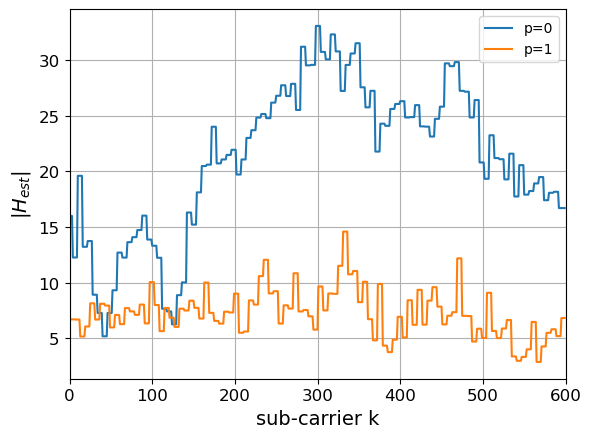

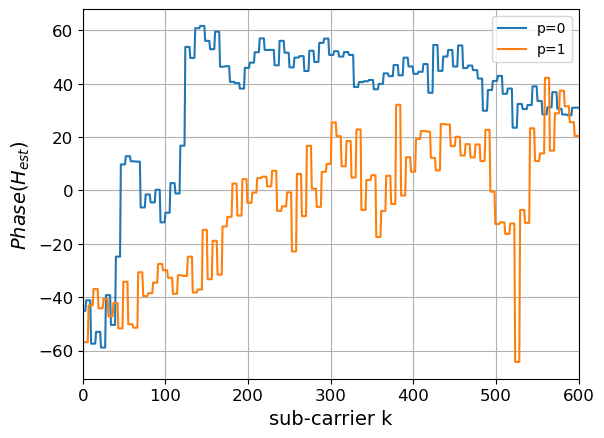

In [540]:
## check that this worked:
# plot magnitude
for p in range(N_ant):
    plt.plot(np.arange(12*N_RB_DL), np.abs(H_0[p,:]), label="p={:d}".format(p))

plt.grid()
plt.xlim(0, N_RB_DL*12)

plt.xlabel('sub-carrier k')
plt.ylabel('$|H_{est}|$')

plt.legend()
plt.show()

# plot phase
for p in range(N_ant):
    plt.plot(np.arange(12*N_RB_DL), 180/np.pi*np.angle(H_0[p,:]), label="p={:d}".format(p))

plt.grid()
plt.xlim(0, N_RB_DL*12)

plt.xlabel('sub-carrier k')
plt.ylabel('$Phase(H_{est})$')

plt.legend()
plt.show()

This looks reasonable; in particular, the phase is relatively smooth. There appear to be a couple of minor fades at lower frequencies for antenna $p=0$. Also, the phase on antenna $p=1$ near subcarrier 500 is suspicious.

Nevertheless, this should be good enough to recover the heavily coded PCFICH. For other signals, we may need to smooth these estimates over multiple symbol periods containing CRS.

### Extract CFI Resource Elements

The location of resource elements holding CFI is specified in section 6.7.4 of TS 36.211:

> The mapping to resource elements is defined in terms of quadruplets of complex-valued symbols. Let
$z^{(p)}(i)= \{y^{(p)}(4i),y^{(p)}(4i+1),y^{(p)}(4i+2),y^{(p)}(4i+3)\}$ denote symbol quadruplet $i$ for antenna port $p$.
For each of
the antenna ports, symbol quadruplets shall be mapped in increasing order of $i$ to the four resource-element groups in the first OFDM symbol in a downlink subframe or DwPTS with the representative resource-element as defined in clause 6.2.4 given by

\begin{align*}
z^{(p)}(0) \text{ is mapped to the resource-element group represented by } & k = \bar{k}\\
z^{(p)}(1) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2\\
z^{(p)}(2) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor 2N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2\\
z^{(p)}(3) \text{ is mapped to the resource-element group represented by } & k = \bar{k} + \lfloor 3N_{RB}^{DL}/2 \rfloor \cdot N_{sc}^{RB}/2
\end{align*}

>where the additions are modulo $N^{DL}_{RB} \cdot N^{RB}_{sc}$,
$$
\bar{k}=(N_{sc}^{RB}/2)\cdot(N_{ID}^{cell} \mod 2 N_{RB}^{DL})
$$
>and $N_{ID}^{cell}$ is the physical-layer cell identity as given by clause 6.11.

The specification references *Resource Element Groups* (REG); these are defined in section 6.2.4 of TS 36.211. In short, A REG comprises four resource elements that are not used for CRS. In other words,
* for OFDM symbols that do not include CRS (e.g., symbol 2), a REG consists of 4 consecutive resource elements; each resource block holds 3 REGs.
* for OFDM symbols that do include CRS (e.g., symbol 0), a CREG is contained in a group of six consecutive REs and the REG excludes the locations of CRS elements; each resource block can hold 2 REGs.

To determine the location of CRS elements, we use the number of antennas in the system; except, for systems with a single antenna, CRS locations are determined as if there were two antennas.

Since the PCFICH is always located in symbol $l=0$, we will have CRS elements on every third RE starting at a value that depends on the cell id and the slot number. The starting value is the smallest index $k$ for the location of CRS computed by function `crs_syms_and_k`.

The function below computes the subcarrier indices that hold PCFICH information symbols.

In [559]:
def PCFICH_locs(N_RB, N_ID_cell, crs_start):
    """Compute subcarrier indices for PCFICH
    
    Inputs:
    N_RB - number of subcarriers 
    N_ID_cell - cell id
    crs_start - first subcarrier that holds a CRS element

    Returns:
    length-16 vector of subcarrier indices
    """
    k_ind = np.zeros(16, dtype=int)

    N_SC_RB = 12
    N_SC_RB_2 = N_SC_RB // 2

    k_bar = N_SC_RB_2 * (N_ID_cell % (2 * N_RB))

    m = 0
    for n in range(4):
        # loop over quadruplets
        k_init = k_bar + ((n*N_RB) // 2) * N_SC_RB_2

        for i in range(6):
            if (i % 3) != crs_start:  # skip CRS
                k_ind[m] = (k_init + i) % (N_RB * N_SC_RB)
                m += 1

    return k_ind

With this function, the freqency locations of the 16 PCFICH REs is easily determined. 

We can obtain the value for `crs_start` from the locations of the CRS elements that were stored in the array of dictionaries `est_H`. 

In the next processing steps, we will use the indices computed by this function to access the PCFICH resource elements and also the associated estimates of the frequency responses.

In [564]:
## get PCFICH locations
# get crs_start from est_H
crs_start = est_H[0]['k'][0] % 3

cfi_k = PCFICH_locs(N_RB_DL, N_ID_cell, crs_start)

### Transmit Diversity (Alamouti) Combining

According to section 6.7.3 of TS 36.211, the resource elements that constitute the PCFICH must now be processed with the Alamouti combining function that we developed during MIB decoding. The number of antenna ports was obtained during MIB decoding. The code below is for two antennas (i.e., the value determined during MIB processing).

In [568]:
## transmit diversity combining
PCFI_syms = SYM0[cfi_k]
PCFI_H_est = H_0[:, cfi_k]

PCFI_x = np.zeros_like(PCFI_syms)

for n in range(len(PCFI_syms) // 2):
    PCFI_x[2*n], PCFI_x[2*n+1] = Alamouti_combine(PCFI_syms[2*n], PCFI_syms[2*n+1], PCFI_H_est[0, 2*n], PCFI_H_est[1, 2*n])


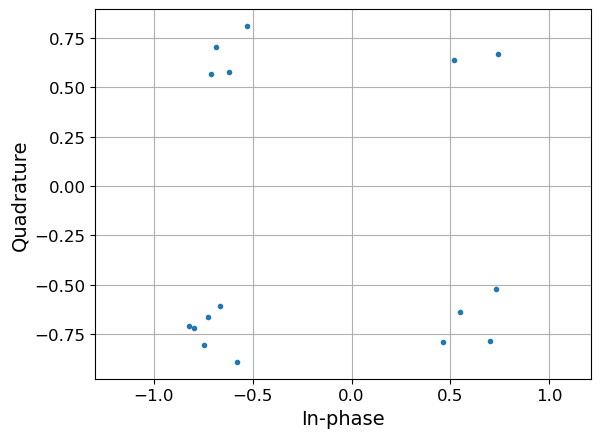

In [570]:
## check that this produces QPSK symbols
plt.plot(PCFI_x.real, PCFI_x.imag, '.')
plt.grid()
plt.axis('equal')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

### QPSK Demodulation

According to section 6.7.2 of TS 36.211, the PCFICH is QPSK modulated. Using the QPSK demodulator functions developed during MIB processing, we obtain scramble PCFICH bits. Both hard and soft-decision bits are collected.


In [571]:
## QPSK demodulation: produces 32 bits
PCFI_scrambled_bits = qpsk_demodulate(PCFI_x)
PCFI_scrambled_bits_soft = qpsk_demodulate_soft(PCFI_x)

## Descrambling

Scrambling for the PCFICH is defined in section 6.7.1 of TS 36.211.

The PCFICH scrambler uses the same pseudo-random number generator $c(n)$ as the PBCH (MIB). However, the initialization is given by:
$$
    c_{init} = (\lfloor n_s/2\rfloor + 1) \cdot (2 N_{ID}^{cell}+1) \cdot 2^9 + N_{ID}^{cell},
$$
where $n_s$ is the slot number, i.e., 10 since we are in subframe 5.

In [573]:
## descramble
# generate the scrambling sequence using c_init
n_s = 10
c_init = (((n_s // 2 + 1) * (2 * N_ID_cell + 1)) << 9) + N_ID_cell

N_bits = len(PCFI_scrambled_bits)  # 480 - a quarter of all bits

c = naive_cn(N_bits, c_init)

PCFI_bits = PCFI_scrambled_bits ^ c
PCFI_bits_soft = PCFI_scrambled_bits_soft * (1. - 2. * c)



### CFI Decoding

The final step in CFI processing is to determine the CFI value from the 32 PCFI bits.

Section 5.3.4.1 in TS 36.212 provides a 32 bit pattern for each of the three possible CFI values (1, 2, 3). 

We use our Hamming and $L_2$ distance functions (used in the Viterbi decoder) to find the best match.

In [598]:
## CFI decoding
# table of bit sequences for each CFI value (Table 5.3.4-1 in TS 36.212)
CFI_code_table = {
    1: np.array([0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1], dtype=np.uint8),
    2: np.array([1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0], dtype=np.uint8),
    3: np.array([1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1], dtype=np.uint8),
}

# compute distances
dist = np.zeros(3)
dist_soft = np.zeros(3)
CFI_vec = np.zeros(3, dtype=int)

n = 0
for CFI_vec[n], cfi_seq in CFI_code_table.items():
    dist[n] = hamming_dist(PCFI_bits, cfi_seq)
    dist_soft[n] = L2_dist(PCFI_bits_soft, cfi_seq)
    n += 1

obs_CFI = CFI_vec[np.argmin(dist)]
obs_CFI_soft = CFI_vec[np.argmin(dist_soft)]

# When BW is low, CFI is one longer than indicated on PCFICH (see Table 6.7-1 in TS 36.211)
if N_RB_DL <= 10:
    CFI = obs_CFI + 1
else:
    CFI = obs_CFI

print('CFI = {:d}. Decoded CFI: hard: {:d} (Hamming distance {:4.0f}, soft: {:d} (L2 distance {:4.2f}'.format(
    CFI, obs_CFI, np.min(dist), obs_CFI_soft, np.min(dist_soft)
))


CFI = 1. Decoded CFI: hard: 1 (Hamming distance    0, soft: 1 (L2 distance 0.73


### Where are we now and what's next?

This completes our processing of the Physical Control Format Indicator Channel. We have successfully determined the subframe that contains SIB1 uses `CFI = 1`. 

That means that in this subframe only one symbol (the first, i.e., symbol 0) is allocated to carry the Physical Downlink Control Channels (PDCCH).

We must process the PDCCH next. The goal is to find the *Downlink Control Indicator* (DCI) that points us to where we find the SIB1 in the remaining symbols of subframe 5.

After that, we can locate and decode SIB1 itself.

## Task: Locate the DCI for SIB1

Processing the PDCCHs and extracting the DCIs is complex and confusing for a number of reasons:

* DCIs support a number of different purposes, including down-link resource allocation, uplink grants, measuremnt requests, power control, etc.
* In each sub-frame there are multiple DCIs that are all carried in the PDCCH (i.e., in symbol 0 in our case). The order in which the DCIs appears is very flexible and requires a trial-and-error approach that is referred to as *blind search*. The concept of control channel elements (CCEs) and search spaces play an important role in restricting the scope of the blind search.
* DCIs are encoded using a significant number of different formats (called DCI Formats). The description of these formats spans more than 50 pages in TS 36.212 section 5.3.3.
* Information pertinent to locating and extracting DCI is spread over multiple standard documents, including TS 36.211 (scrambling, modulation, transmit diversity and resource mapping), TS 36.212 (DCI Formats), and TS 36.212 (meaning of DCI fields)

On the good-news side, DCI is encoded the same way as the MIB, i.e., with the sequence of CRC, convolutional code, rate matching, scrambling, modulation, and transmit diversity. Hence, we will not require additional signal processing functions.

### Where exactly are the PDCCHs

The first thing, we need to determine is where exactly we need to look for resource elements that comprise the PDCCHs.

The CFI told us that only one OFDM symbol in subframe 5, symbol 0, is allocated to carry the PDCCH. 

The problem is that symbol 0 also carries CRS, the PCFICH, and the PHICH (Physical Hybrid ARQ Channel). The PDCCH can use all resource elements that aren't allocated to one of these three purposes.

We're familiar with the first two. For our purposes, we do not care about the contents of the PHICH. However, we must determine which REs are occupied by the PHICH. We must figure that out first.

#### Detour: Where is the PHICH?

We only need to know where the PHICH Resource elements are located; their contents is of no interest to us. Section 6.9 of TS 36.211 escribes the PHICH.

It is easiest to describe the PHICH location in terms of REGs. Recall that REGs contain four non-CRS resource elements. And, since symbol 0 does contain CRS, each PRB contains two REGs. There is a total of 100 REGs when the bandwidth consists of $N_{RB}^{DL}$ resource blocks. We saw that four of these are occupied by the PCFICH. This leaves 96 REGs.

According to section 6.9 of TS 36.211, the number of REGs occupied by the PHICH depends on a quantity called the PHICH groups $N_{PHICH}^{group}$. This quantity depends on information provided by the MIB, specifically, the number of downlink resource blocks $N_{RB}^{DL}$ and the PHICH parameter `phich-Resource` (which was decoded as `one`). For the normal cyclic prefix
$$
N_{PHICH}^{group} = \lceil N_g \cdot (N_{RB}^{DL}/8) \rceil,
$$
where $N_g \in \{1/6, 1/2, 1, 2\}$ is selected by `phich-Resource`.

For our parameters, $N_{PHICH}^{group} = \lceil 1 \cdot 50/8) \rceil = 7$. Section 6.9.3 implies that $7 \dot 3 = 21$ REGs will be allocated to the PHICH.

To determine the REGs that are assigned to the PHICH, section 6.9.3 specifies an algorithm that causes REGs in three evenly spaced clusters of REGs - each of size $N_{PHICH}^{group}$ - to be allocated. In the allocation, REGs allocated to the PCFICH are skipped.

All PHICH resource elements go in the first symbol since the the control section of the subframe is only one symbol long and because `phich-Duration` was indicated as `normal`. When this is not true, some PHICH symbols can go in the second symbol as well. (see section 6.9.3)

Below, we compute the sets of REGs occupied by the PCFICH and the PHICH and determine which REGs are left for the PDCCH.

In [622]:
## Figure out which REGS a re used by PCFICH, PHICH, and what is left
# start will all REGs
all_REG = {n for n in range(2*N_RB_DL)}

# PCFICH REGs are fairly easy 
PCFI_REG = {(N_ID_cell % (2*N_RB_DL) + ((n*N_RB_DL) // 2) % (2*N_RB_DL)) for n in range(4)}

# this is what's left for PHICH and PDCCH
all_REG.difference_update(PCFI_REG)
all_REG_vec = np.sort(np.array([n for n in all_REG]))
n_0 = len(all_REG)

# now deal with the PHICH
PHICH_REG = set()

# note: this is specific to FDD and normal CP
Ng = 1   # this reflects phich-Resource from MIB
N_group = (Ng * N_RB_DL) // 8
if 8*N_group < Ng * N_RB_DL:
    N_group += 1

for m in range(N_group):
    for i in range(3):
        n_i = (N_ID_cell + m + ((i*n_0) // 3)) % n_0 # index into all_REG_vec
        reg = all_REG_vec[n_i]   # the actual REG
        
        # move REG from all_REG to PHICH_REG
        all_REG.discard(reg)
        PHICH_REG.add(reg)
        
print("After PCFICH and PHICH, there are {:d} REGs left for the PDCCH".format(len(all_REG)))

After PCFICH and PHICH, there are 75 REGs left for the PDCCH


### Control Channel Elements (CCE)

The information in the Control Region of the frame (symbol 0 in our case), is organized into a number of PDCCH channels arccording to the following principles set forth in section 6.8.1 of TS 36.211:

> The physical downlink control channel carries scheduling assignments and other control information. A physical control channel is transmitted on an aggregation of one or several consecutive control channel elements (CCEs), where a control channel element corresponds to 9 resource element groups. The number of resource-element groups not assigned to PCFICH or PHICH is $N_{REG}$. The CCEs available in the system are numbered from $0$ to $N_{CCE} −1$, where
$N_{CCE} = \lfloor N_{REG} / 9 \rfloor$. The PDCCH supports multiple formats as listed in Table 6.8.1-1. A PDCCH consisting of $n$
consecutive CCEs may only start on a CCE fulfilling $i \mod n = 0$ , where $i$ is the CCE number. 

>Multiple PDCCHs can be transmitted in a subframe. 

![PDCCH_FOrmats](PDCCH_Formats.png)

We just saw that in this subframe, there are $N_{REG}=75$ REGs available for control information. 

Hence, there are $N_{CCE} = \lfloor N_{REG} / 9 \rfloor = 8$ CCEs available

### From DCIs to CCEs

Recall that downlink control information (DCI) is the information to be conveyed on the control channel.

Each DCI is protected by CRC attachment, FEC coding (rate 1/3 convolutional code), and then rate matched to produce a number of bits that matches the number of bits available in the CCEs of a given aggregation level. 

The System Information, including SIB1, is carried in either 4 or 8 CCEs. 

### Search Spaces

All PDCCHs are multiplexed into a single block; the (coded) bits comprising a PDCCH are concatenated back-to-back with the constraint that a PDCCH consisting of $n$ CCEs must begin on a CCE that is divisible by $n$. The entire block of (possible) multiple PDCCHs is then scrambled, modulated, space-time coded and finally mapped to the available REGs in the control region. This final step includes additional interleaving to improve frequency diversity.

This brings up a **question**: which of the sequence of PDCCHs is the one I need to recover?

**Answer**: try several and see if you find the right one! Specifically, try two PDCCHs with 8 CCEs (starting a CCE numbers 0 and 8) and four PDCCHs with aggregation level 4 (starting at CCE numbers 0, 4, 8, 12).

But, that creates another **question**: How do I know I found the right one?

**Answer**: See if the CRC checks out.

But, that's still not good enough! **Question**: I need to know how many bits are in the payload to undo the rate matching.

**Answer**: There are only two possibilities (for each bandwidth and mode). They are called DCI Format 1A and DCI Format 1C. Try them both!

The process described above is called *Blind Search*. It stipulates that the UE must try (up to) 12 possible PDCCH/DCI combinations.



## What's next:

* Implement the Blind Search Procedure: we can re-use a lot of code, but the final interleaving is new. To facilitate the search, we need a single (or two) functions to performs the entire decoding procedure.
* Decode the DCI according to section 5.3.3 in TS 36.212. Need decoder for DCI Format 1A and 1C.

That will provide us with the information required to locate where the SIB1 samples are in the subframe and how it is modulated and coded. To recover the SIB1, we need:
* extract the received symbols holding the SIB 
* process them through space-time coding, demodulation, scrambling, rate matching, decoding, and CRC.  
The problem is that an entirely different FEC *turbo code) and rate matching (and possibly others) is used. Hence, there is little re-use of what we have already.